In [1]:
import torch
import random
import os
from torch import nn
from torch.utils.data import Dataset,DataLoader

corpus_file = 'hw2.1_corpus.txt'

In [2]:
# Load Corpus

corpus = []
with open(corpus_file, 'r', encoding='utf-8') as f:
    for row in f:
        row = row.replace('\n','')
        row = [w for w in row]
        corpus.append(row)

In [3]:
# Use list to guarantee the embedded index for each word are same everytime

words = []
words_set = set()
for ws in corpus:
    for w in ws:
        if w not in words_set:
            words_set.add(w)
            words.append(w)

In [4]:
import re

class Embedding:

    def __init__(self,words=None,dim=300):
        self.word_dict = {}
        self.word_list = []
        self.emb_dim = dim
        self.maxPOS = 55      # Maximum POS
        self.addition_words = ['<PAD>','<SOS>','<EOS>','<UNK>']
        
        for POS in range(self.maxPOS):
            self.addition_words.append(str(POS))
        
        for addition_word in self.addition_words:
            if addition_word not in words:
                self.word_dict[addition_word] = len(self.word_list)
                self.word_list.append(addition_word)
        
        for word in words:
            if word not in self.word_dict:
                self.word_dict[word] = len(self.word_list)
                self.word_list.append(word)
                
        self.vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict),dim))
        
    def to_index(self, word):
        # single word tokenize
        if word not in self.word_dict:
            return self.word_dict['<UNK>']
        
        return self.word_dict[word]
        
    def tokenize(self, words):
        # whole sentence tokenize
        return [self.to_index(w) for w in words]
    
    def to_word(self, idx):
        
        return self.word_list[idx]
        
    def unTokenize(self,ids):
        
        return [self.to_word(idx) for idx in ids]
        
    def get_vocabulary_size(self):
        return self.vectors.shape[0]
    
    def get_dim(self):
        return self.vectors.shape[1]

In [5]:
# establish embedder to tokenize
embedder = Embedding(words=words,dim=300)

PAD = embedder.to_index('<PAD>')
SOS = embedder.to_index('<SOS>')
EOS = embedder.to_index('<EOS>')

In [6]:
all_set = []
two_hint_ratio = 0.0

for former,latter in zip(corpus[:-1],corpus[1:]):
    
    n = len(latter)
    addition_tokens = []
    
    hint_word = 2 if random.random() < two_hint_ratio else 1

    selected_idice = random.sample(list(range(min(n,embedder.maxPOS))), k=min(n,hint_word))
    
    for selected_idx in selected_idice:
        
        addition_tokens.append(str(selected_idx+1))
        addition_tokens.append(latter[selected_idx])
    
    former = ['<SOS>'] + former + ['<EOS>'] + addition_tokens
    latter = ['<SOS>'] + latter + ['<EOS>']
    
    
    all_set.append((former,latter))

In [7]:
from sklearn.model_selection import train_test_split

train_set,valid_set = train_test_split(all_set,test_size=0.2,random_state=42)

print(len(all_set),len(train_set),len(valid_set))

741714 593371 148343


In [8]:
# list of turple : [(x0,y0),(x1,y1),(x2,y2),....]
all_set[5]

(['<SOS>',
  '你',
  '最',
  '想',
  '去',
  '的',
  '目',
  '的',
  '地',
  '剩',
  '多',
  '少',
  '公',
  '里',
  '<EOS>',
  '5',
  '关'],
 ['<SOS>', '累', '了', '也', '没', '关', '系', '我', '可', '以', '暂', '停', '<EOS>'])

In [9]:

class SentDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_data_len = max([len(data[0]) for data in datas])
        max_label_len = max([len(data[1]) for data in datas])
        
        batch_x = []
        batch_y = []
        len_x = []
        len_y = []
        batch_y_ = []
        
        
        for data,label in datas:
            
            len_x.append(len(data))
            len_y.append(len(label))
            
            # Tokenize
            pad_data = embedder.tokenize(data)
            pad_label = embedder.tokenize(label)
            
            # Padding data and label
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            if len(label) < max_label_len:
                pad_label.extend([PAD] * (max_label_len-len(label)))
                
                
            batch_x.append(pad_data)
            batch_y.append(pad_label)
            
            # generate y_
            focus_designate = [PAD] * len(pad_label)
            focus_designate[0] = SOS
            focus_designate[pad_label.index(EOS)] = EOS
            
            for i in range(data.index('<EOS>')+1,len(data),2):
                
                idx = int(data[i])
                focus_designate[idx] = pad_label[idx]
            
            batch_y_.append(focus_designate)
            
            
        return torch.LongTensor(batch_x), torch.LongTensor(len_x), torch.LongTensor(batch_y), len_y, torch.LongTensor(batch_y_)

In [10]:
# For Validate~~~~

dataset = SentDataset(train_set)
dataloader = DataLoader(dataset=dataset,
                        batch_size=4,
                        shuffle=True,
                        collate_fn=dataset.collate_fn,
                        num_workers=0)
for x,x_len,y,y_len,y_ in dataloader:
    print('Sentence length:',x_len,y_len,'\n')
    
    for xi,yi,y_i in zip(x,y,y_):      
        
        print(embedder.unTokenize(xi))
        print(embedder.unTokenize(yi))
        print(embedder.unTokenize(y_i),'\n')
    
    break


Sentence length: tensor([18, 13,  9, 11]) [14, 13, 8, 8] 

['<SOS>', '房', '间', '很', '温', '暖', '不', '需', '要', '穿', '臃', '肿', '的', '棉', '衣', '<EOS>', '4', '再']
['<SOS>', '我', '已', '不', '再', '像', '从', '前', '总', '抽', '太', '多', '烟', '<EOS>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '再', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EOS>'] 

['<SOS>', '低', '调', '平', '庸', '卑', '微', '我', '不', '会', '<EOS>', '8', '如', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '爱', '美', '我', '就', '是', '如', '此', '如', '此', '爱', '美', '<EOS>', '<PAD>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '如', '<PAD>', '<PAD>', '<PAD>', '<EOS>', '<PAD>'] 

['<SOS>', '爱', '人', '不', '见', '了', '<EOS>', '6', '早', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '清', '醒', '还', '要', '趁', '早', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '早', '<EOS>', '<PA

In [11]:
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size):
        
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedder.get_dim())
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.gru = nn.GRU(embedding_size, output_size,batch_first=True, bias=False)

    def forward(self, input_seqs, input_lengths, hidden=None):
        
        # Sort mini-batch by input_lengths
        sorted_input_lengths, indices = torch.sort(input_lengths,descending=True)
        _, desorted_indices = torch.sort(indices, descending=False)
        input_seqs = input_seqs[indices]
        
        # Encoder work
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, sorted_input_lengths.cpu().numpy(), batch_first=True)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs,batch_first=True)
        
        # Desort mini-batch
        outputs = outputs[desorted_indices]
        hidden = hidden[:,desorted_indices]
        
        return outputs, hidden

In [12]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, teacher_forcing_ratio=0.5):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim()) # Unused
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.cell = nn.GRUCell(embedder.get_dim(), hidden_size, bias=False)
        self.clf = nn.Linear(hidden_size, output_size, bias=False)
        
        if hidden_size == embedder.vectors.T.shape[0]:
            self.clf.weight = nn.Parameter(embedder.vectors)

        self.log_softmax = nn.LogSoftmax(dim=1)  # work with NLLLoss

        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward_step(self, inputs, hidden):
        
        # Unused
        embedded = self.embedding(inputs)
        # For research : all x to 0
        embedded = torch.zeros_like(embedded)
        
        hidden = self.cell(embedded, hidden) # [B,Hidden_dim]
        clf_output = self.clf(hidden) # [B,Output_dim]
        output = self.log_softmax(clf_output)

        return output, hidden

    def forward(self, context_vector, target_vars, target_lengths):

        batch_size = context_vector.shape[1]
        
        decoder_input = torch.LongTensor([SOS] * batch_size).to(device)
        decoder_hidden = context_vector.squeeze(0)

        if target_lengths is None:
            max_target_length = 50
        else:
            max_target_length = max(target_lengths)
        decoder_outputs = []
        decoder_hiddens = []

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        for t in range(max_target_length):    
            
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_outputs_on_t)
            decoder_hiddens.append(decoder_hidden)
            
            # Take input for next GRU iteration
            if use_teacher_forcing :
                decoder_input = target_vars[:,t]
            else:
                decoder_input = decoder_outputs_on_t.argmax(-1)
            
            # Early Stop when all predict <EOS> 
            if torch.all(decoder_input==EOS) and target_lengths is None and self.train() == False:
                break
            
        # Stack output of each word at dimension 2
        decoder_outputs = torch.stack(decoder_outputs,dim=2)
        # Stack hidden of each timestep at dimension 1
        decoder_hiddens = torch.stack(decoder_hiddens,dim=1)
        
        return decoder_outputs, decoder_hiddens

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input_seqs, input_lengths, target_seqs=None, target_lengths=None):
        outputs, hidden = encoder(input_seqs, input_lengths)
        outputs, hiddens = decoder(hidden, target_seqs, target_lengths)
        return outputs,hiddens

In [14]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

context_dim = 128

encoder = Encoder(embedder.get_vocabulary_size(),embedder.get_dim(),output_size=context_dim)
decoder = Decoder(context_dim,embedder.get_vocabulary_size(),0.5)
model = Seq2Seq(encoder,decoder)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6618, 300)
    (gru): GRU(300, 128, bias=False, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6618, 300)
    (cell): GRUCell(300, 128, bias=False)
    (clf): Linear(in_features=128, out_features=6618, bias=False)
    (log_softmax): LogSoftmax()
  )
)

# Training ( Dont run when analysing )

In [15]:
# def run_epoch(epoch,dataset,isTraining):
    
#     if isTraining:
#         model.train()
#     else:
#         model.eval()
        
#     dataloader = DataLoader(dataset=dataset,
#                             batch_size=32,
#                             shuffle=True,
#                             collate_fn=dataset.collate_fn,
#                             num_workers=0)
    
#     if isTraining:
#         desc='Train {}'
#     else:
#         desc='Valid {}'
    
#     trange = tqdm(enumerate(dataloader), total=len(dataloader),desc=desc.format(epoch))
    
#     loss=0
#     acc = 0
    
#     for i,(x,x_len,y,y_len,y_) in trange:
        
#         x = x.to(device)
#         y = y.to(device)
#         y_ = y_.to(device)
        
#         # outputs : [b,emb,s] , hiddens : [b,s,hidden]
#         outputs,hiddens = model(x,x_len,y,y_len)
        
#         idx = y_>2
#         tf_map = y_[idx] == outputs.argmax(1)[idx]
#         batch_acc = tf_map.sum().cpu().float().numpy()/len(tf_map)
#         acc += batch_acc
        
#         batch_loss_all = criterion(outputs, y)
#         batch_loss_designated = criterion(outputs, y_)
#         batch_loss = (1-focus_ratio)*batch_loss_all + focus_ratio*batch_loss_designated
        
#         if isTraining:
#             optimizer.zero_grad()
#             batch_loss.backward()
#             optimizer.step()
        
#         loss += batch_loss.item()
        
#         trange.set_postfix({'loss':loss/(i+1),'accuracy':acc/(i+1)})
        
#         if isTraining:
#             history_loss['train'].append(batch_loss.item())
#             history_acc['train'].append(batch_acc)
#         else:
#             history_loss['valid'].append(batch_loss.item())
#             history_acc['valid'].append(batch_acc)

In [16]:
# # Training

# dataset_all = SentDataset(all_set)
# dataset_train = SentDataset(train_set)
# dataset_valid = SentDataset(valid_set)

# criterion = torch.nn.NLLLoss(ignore_index=PAD, size_average=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# max_epoch = 20
# focus_ratio = 0.5

# history_loss = {'train':[],'valid':[]}
# history_acc = {'train':[],'valid':[]}


# for epoch in range(max_epoch):
    
#     # Training
#     run_epoch(epoch,dataset=dataset_train,isTraining=True)
    
#     # Validation
#     run_epoch(epoch,dataset=dataset_valid,isTraining=False)
    
#     # Saving
#     if not os.path.exists('model'):
#         os.makedirs('model')
#     torch.save(model.state_dict(), 'model/model.pkl.{}'.format(epoch))

# Plot (Loss and acc)  ( Dont run when analysis )

In [17]:
import matplotlib.pyplot as plt

# modes = ['train', 'valid']
# recs = [history_loss, history_acc]
# names = ['Loss', 'Accuracy']

# values = []
# for mode in modes:
#     v = []
#     for rec in recs:
#         v.append(rec[mode])
#     values.append(v)

# plt.figure(figsize=(32, 4))
# plt.subplots_adjust(left=0.02, right=0.999)
# for r, name in enumerate(names):
#     plt.subplot(1, len(recs), r+1)
#     for m in range(len(modes)):
#         plt.plot(values[m][r])
#     plt.title(name)
#     plt.legend(modes)
#     plt.xlabel('iteration')
#     plt.show()
# #plt.savefig('figure.png', dpi=100)

## Convert models into directly-pickled format to solve cross-platform inconsistency

In [18]:
# import pickle

# path = 'pre-train/model.pkl.2-1-1'
# with open(path+'.state_dict', 'wb') as f:
#     pickle.dump(model.cpu().state_dict(), f)

# Inference Test Data

## Define test data dataloader

In [19]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        max_data_len = max([len(data) for data in datas])
        batch_x = []
        len_x = []
        
        for data in datas:
            len_x.append(len(data))
            pad_data = [embedder.to_index(w) for w in data]
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            batch_x.append(pad_data)

        return torch.LongTensor(batch_x), torch.LongTensor(len_x)

## Load pre-trained model

In [20]:
path_pkl = 'pre-train/model.pkl.2-1-1'
directly_pickled_format = True

if directly_pickled_format:
    import pickle
    with open(path_pkl+'.state_dict', 'rb') as f:
        state_dict = pickle.load(f)
    for par_name in list(state_dict):
        path = par_name.split('.')
        obj = model
        for attr in path[:-1]:
            obj = getattr(obj, attr)
        setattr(obj, path[-1], torch.nn.Parameter(state_dict[par_name]))
    model.to(device)
else:
    model.load_state_dict(torch.load(path_pkl, map_location=device))
    model.decoder.teacher_forcing_ratio = 0.0
    model.eval()

## Weight analysis

In [21]:
import numpy as np

In [22]:
W_hh = model.decoder.cell.weight_hh.detach().cpu().numpy()
W_hr, W_hz, W_hn = W_hh[0:128], W_hh[128:256], W_hh[256:384]

In [23]:
print('ratio of power on diagonal:')
weights = {'reset':W_hr, 'input':W_hz, 'new':W_hn}
for name, w in weights.items():
    print(name+'\t', np.linalg.norm(np.multiply(w, np.eye(128)), ord='fro') / np.linalg.norm(w, ord='fro'))

ratio of power on diagonal:
reset	 0.1610155865548972
input	 0.2460820475262698
new	 0.16719531104402513


reset


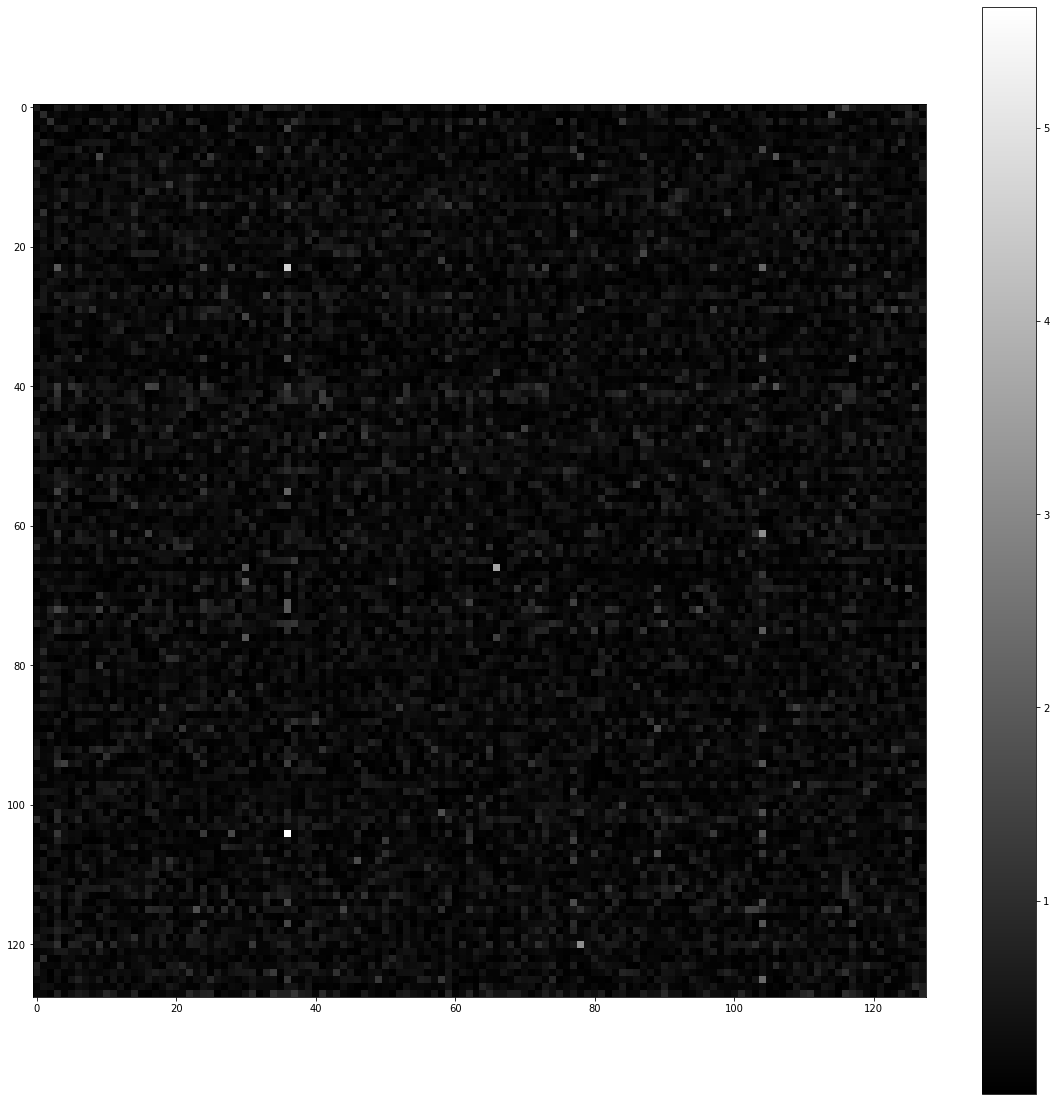

input


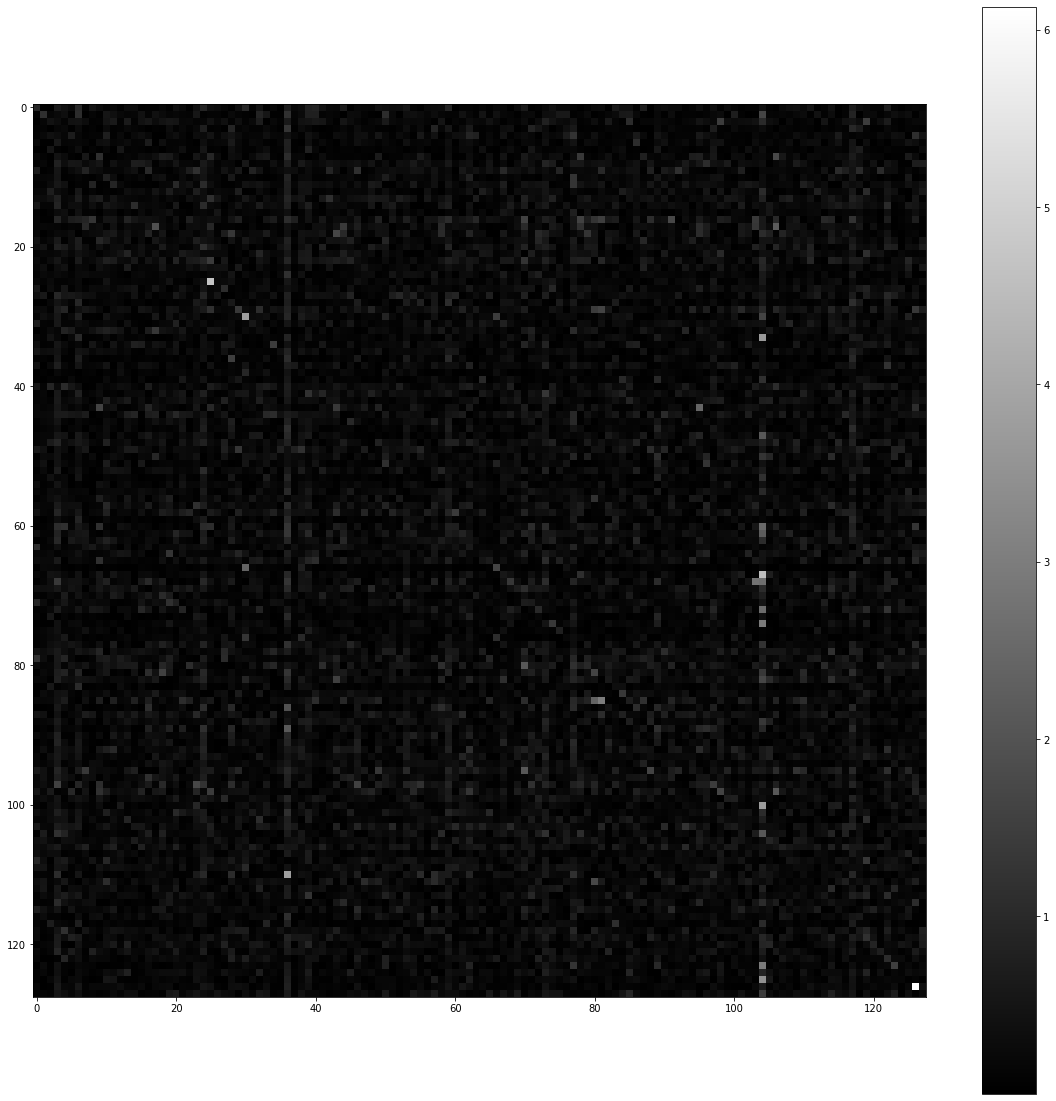

new


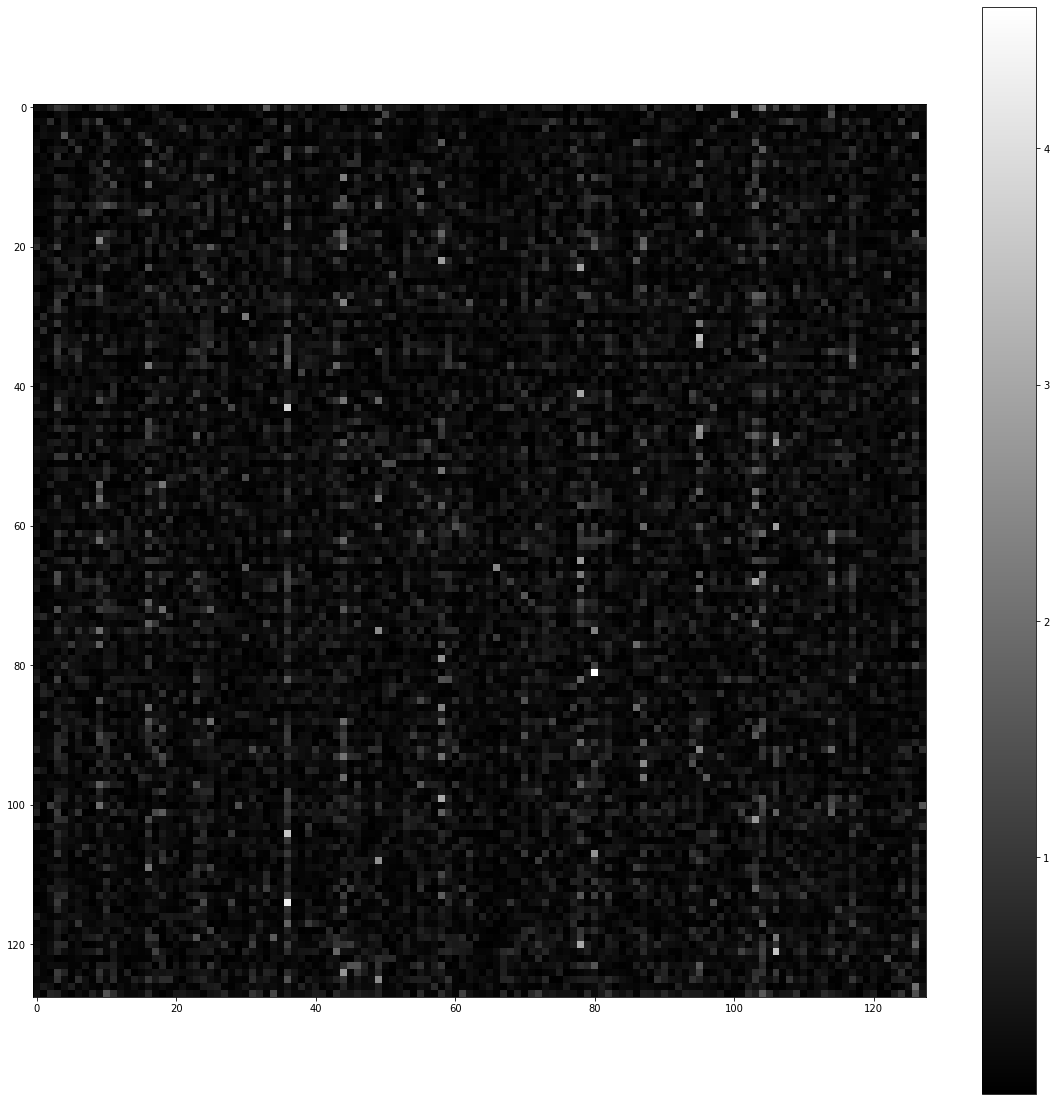

In [24]:
weights = {'reset':W_hr, 'input':W_hz, 'new':W_hn}
for name, W in weights.items():
    print(name)
    plt.subplots(figsize=(20,20))
    plt.imshow(np.abs(W), cmap='gray')
    plt.colorbar()
    plt.show()

## Implement GRU Cell to collect neuorn states while inferencing

In [353]:
import torch.nn.functional as F


def Deconstruction(model,x,x_len, disabled_cells=[], mask_type="hidden"):
    assert mask_type in ['hidden', 'Un_h']
    # Encoder 
    encoder_hiddens, context = model.encoder(x,x_len)
    
    # Decoder
    decoder_hidden = context.squeeze(0)
    
    # Collection signal
    decoder_outputs = []
    decoder_hiddens = []
    decoder_resetGates = []
    decoder_updateGates = []
    decoder_newGates = []
    
    for iteration in range(15):
        
        # GRU Cell
        gru = model.decoder.cell
        
        U_h = F.linear(decoder_hidden, gru.weight_hh)
        Ur_h, Uz_h, Un_h = U_h.chunk(3, 1)
        reset_gate = torch.sigmoid(Ur_h)
        update_gate = torch.sigmoid(Uz_h)
        if len(disabled_cells) > 0 and mask_type == 'Un_h':
            mask = torch.ones(128).cuda()
            for cell in disabled_cells:
                mask[cell] = 0
            Un_h *= mask
        new_gate = torch.tanh(reset_gate * Un_h)
        decoder_hidden = new_gate + update_gate * (decoder_hidden - new_gate)
        
        # Classifier
        clf_output = model.decoder.clf(decoder_hidden)
        decoder_output = model.decoder.log_softmax(clf_output)
        
        # mask specific cells
        if len(disabled_cells) > 0 and mask_type == 'hidden':
            mask = torch.ones(128).cuda()
            for cell in disabled_cells:
                mask[cell] = 0
            decoder_hidden *= mask
        
        # save states
        decoder_resetGates.append(reset_gate)
        decoder_updateGates.append(update_gate)
        decoder_newGates.append(new_gate)
        decoder_outputs.append(decoder_output)            
        decoder_hiddens.append(decoder_hidden)
                                                   
        if torch.all(decoder_output.argmax(-1)==EOS) == True:
            break
            
    outputs = torch.stack(decoder_outputs,dim=2)             # (b,6xxx,s)
    
    gru_info = {
        'hiddens':torch.stack(decoder_hiddens,dim=2),             # (b,128,s)
        'resetgates':torch.stack(decoder_resetGates,dim=2),       # (b,128,s)
        'updategates':torch.stack(decoder_updateGates,dim=2),     # (b,128,s)
        'newgates':torch.stack(decoder_newGates,dim=2)            # (b,128,s)
    }
    
    return outputs, gru_info

## Generate certain condition valid datas ( by designated word / position filter )

In [64]:
def get_certain_set(pos, word, show=False, batch_size=16):
    certain_set = []

    designated_POS = pos
    designated_word = word

    for sent in random.sample(corpus, k=batch_size):

        control_signal = [str(designated_POS) , designated_word]

        data = ['<SOS>'] + sent + ['<EOS>'] + control_signal

        if show:
            print(data)

        certain_set.append(data)

    dataset_certain = TestDataset(certain_set)
    return dataset_certain

## Prediction certain condition data

In [357]:
def predict(dataset, batch_size=16, disabled_cells=[], mask_type='hidden'):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=dataset.collate_fn,
                            num_workers=0)

    predictions = []
#     trange = tqdm(dataloader, total=len(dataloader))

    for x,x_len in dataloader:

        x = x.to(device)

        outputs, gru_info = Deconstruction(model,x,x_len, disabled_cells, mask_type=mask_type)

        for pred in outputs.cpu().detach().numpy().argmax(1):
            predictions.append(pred)
    return predictions, gru_info

In [28]:
def untokenize_output(dataset, predictions):
    # Process multi-EOS tokens
    predictions_set = []
    for p in predictions:
        p = list(p)
        if EOS in p:
            p = p[:p.index(EOS)+1]
        else:
            p.append(EOS)
        predictions_set.append(embedder.unTokenize(p))

    for sent_id in range(len(dataset)):
        sent_in = ''.join(dataset[sent_id])
        sent_pred = ''.join(predictions_set[sent_id])
        print(f'input:\t{sent_in}\npred:\t{sent_pred}\n')

## Cell classification

In [29]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_cells(cells, include='all', exclude=None, show_legend = False, ylim=(0, 1)):
    '''
    Plot line chart of cells in the set "include - exclude".
    
    :param ndarray(float) cells: Shape = (128, s)
    :param set(int) inlcude: Indices of "cells"
    :param set(int) exclude: Indices of "cells"
    :param bool show_legend: For plotting
    :param tuple(float) ylim: For plotting
    '''
    if include=='all':
        include = set(range(cells.shape[0]))
    picked = include-exclude if exclude else include
    print('cells:', sorted(list(picked)))
    
    x = np.arange(output_len)
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.xlim((0, output_len))
    plt.ylim(ylim)
    for i, cell in enumerate(cells):
        if i in picked:
            plt.plot(x, cell, label=f'cell {i}')
    if show_legend:
        leg = ax.legend(loc='upper right', shadow=True)
    plt.title(f'{len(picked)} cells')
    plt.show()
    
def hist_cells(diff, max_diff):
    '''
    Plot histogram of "diff".
    
    :param array(float) diff: Shape = (n_cells, )
    :param float max_diff: For plotting
    '''
    fig, ax = plt.subplots(figsize=(16, 3))
    n, bins, patches = plt.hist(diff, bins=20, range=(0, max_diff))
    ax.set_xticks(bins)
    for i in range(len(n)):
        plt.text(bins[i], n[i], str(n[i]))

def get_set(cells, feature, mask=None, criterion=lambda d: True, max_diff=0.5, include='all'):
    '''
    get the set of cells close to "feature" and satisfying "criterion" weighted by "mask".
    :param ndarray(float) cells: Shape = (128, s)
    :param array(float) feature: Shape = (s, )
    :param array(float) mask: Shape = (s, )
    :param lambda float->bool criterion: Reture True if diff is in the desired range
    :return set(int): picked indices
    '''
    feature = np.array(feature)
    mask = np.ones(cells.shape[1]) if mask==None else np.array(mask)
    
    if include=='all':
        include = set(range(cells.shape[0]))
    
    diffs = np.zeros(cells.shape[0])
    picked = set()
    for i, cell in enumerate(cells):
        diffs[i] = np.sqrt(np.sum(np.square(cell-feature)*mask)/np.sum(mask))
        if (i in include) and criterion(diffs[i]):
            picked.add(i)
    others = set(range(len(cells))) - picked
    
    hist_cells([diffs[i] for i in picked], max_diff)
    plt.title(f'picked: {len(picked)}')
    hist_cells([diffs[i] for i in others], max_diff)
    plt.title(f'others: {len(others)}')
    plot_cells(cells, include=picked, show_legend=True)
    return picked

def cluster(point_list, n_clusters):
    '''
    Use k-means to find cells with similar trend.
    The returned lists are ordered so that similar groups are close.
    
    :param ndarray(float) point_list: Shape = (128, s)]
    :param int n_clusters: For k-means
    :return tuple(list, list): reordered groups and centers:
        groups: list(list(int))
        centers: list(ndarray(shape=(s,)))
    '''
    # k-means
    kmeans = KMeans(n_clusters, random_state=0, n_jobs=-1).fit(point_list)
    dist_s2c = kmeans.inertia_/len(point_list)
    print('average of squared distances of samples to centers:', dist_s2c)
    m = kmeans.cluster_centers_
    dist_matrix = ((m[None, :, :] - m[:, None, :])**2)
    dist_c2c = dist_matrix.sum() / (n_clusters*(n_clusters-1))
    dist_matrix = dist_matrix.sum(2)**0.5
    print('average of squared distances of centers to centers:', dist_c2c)
    print('ratio:', dist_c2c/dist_s2c)
    
    # collect groups
    groups = []
    for i in range(n_clusters):
        groups.append([])
    for i, l in enumerate(kmeans.labels_):
        groups[l].append(i)

    # order the groups so that similar groups are close in the list
    dist_dict = {}
    for i in range(0, n_clusters):
        for j in range(0, i+1):
            dist = dist_matrix[i,j]
            if dist in dist_dict:
                dist_dict[dist].append((i,j))
            else:
                dist_dict[dist]=[(i,j)]
    group_pairs = []
    for dist in sorted(dist_dict.keys())[1:]:
        group_pairs += dist_dict[dist]
    draw = group_pairs[0][0]
    group_idx = [draw]
    while group_pairs:
        pair = group_pairs[0]
        draw = pair[0] if pair[1]==draw else pair[1]
        group_idx.append(draw)
        filtered_pairs = []
        for pair in group_pairs:
            if draw not in pair:
                filtered_pairs.append(pair)
        group_pairs = filtered_pairs
    
    sorted_groups = []
    sorted_centers = []
    for i in group_idx:
        sorted_groups.append(groups[i])
        sorted_centers.append(kmeans.cluster_centers_[i])
    return sorted_groups, sorted_centers

def analyze_cells(cells, n_clusters, ylim=(0, 1)):
    '''
    plot all groups in "cells"
    
    :param ndarray(float) cells: Shape = (128, s)
    :param int n_clusters: For k-means
    :param tuple(float) ylim: For plotting
    '''
    groups, centers = cluster(cells, n_clusters)
    for i, group in enumerate(groups):
        print('-----------------------------')
        print(f'group {i}: {centers[i]}')
        plot_cells(cells, include=group, show_legend=True, ylim=ylim)

def draw(string):
    import random
    idx = random.randrange(len(string))
    print(string[idx])
    return string[idx]

In [30]:
disabled_cells = {}
# disabled_cells = {9, 16, 44, 49, 58, 70, 78, 80, 87, 95, 103, 106, 126}
# disabled_cells = {*cell_types['EOS']}
# disabled_cells = {4, 9, 16, 18, 44, 49, 50, 58, 77, 78, 80, 87, 95, 103, 106, 116}

In [31]:
# cell_types['EOS']

NameError: name 'cell_types' is not defined

# >>>> Animation part

In [395]:
def generate_data(batch_size=16, designated_POS_type='random', designated_POS_num=2, mean=False, disabled_cells=[]):
    if designated_POS_type == 'random':
        rand_sent = random.choice(corpus)
        designated_word = random.sample(rand_sent,k=1)[0]
#         print(designated_word)
    elif designated_POS_type == 'custom':
        designated_word = draw('张朦胧的话只是无聊的暗号')
    else:
        raise NotImplementedError
    certain_set = get_certain_set(designated_POS_num, designated_word)
    predictions, gru_info = predict(certain_set, disabled_cells=disabled_cells)
    
    output_len = gru_info['updategates'].shape[1]
    if mean:
        gates = {'updategates': gru_info['updategates'].mean(0).detach().cpu().numpy(),
             'resetgates': gru_info['resetgates'].mean(0).detach().cpu().numpy(),
             'newgates': gru_info['newgates'].mean(0).detach().cpu().numpy(),
             'hidden': gru_info['hiddens'].mean(0).detach().cpu().numpy(),# (b,128,s)
            } 
    else:
        gates = {'updategates': gru_info['updategates'].detach().cpu().numpy(),
                 'resetgates': gru_info['resetgates'].detach().cpu().numpy(),
                 'newgates': gru_info['newgates'].detach().cpu().numpy(),
                 'hidden': gru_info['hiddens'].detach().cpu().numpy(),# (b,128,s)
                } 
    return gates, designated_POS_num

In [396]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import pandas as pd
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

In [397]:
def animate(designated_POS, axes, sent_length, hightlight_cells=None, 
            vector_types=['updategates', 'resetgates', 'newgates', 'hidden']):
#     plt.cla()
#     vector_types = ['updategates', 'resetgates', 'newgates', 'hidden']
    decoder_data, designated_POS_num = generate_data(mean=True, designated_POS_num=designated_POS)
#     print(len(axes))

#     if len(axes) > 1:
#         axes = [item for sublist in axes for item in sublist]
    for i, ax in enumerate(axes):
        ax.cla()
        vector_type = vector_types[i]
        ax.set_xlim(1,sent_length + 1)
        ax.set_xticks(range(1,sent_length + 2))
        
#         print(decoder_data[vector_type].shape)
        hidden_dim, output_len = decoder_data[vector_type].shape

#         print(hidden_dim, output_len)
#         print('>>>>>>>>>>>>>>>', decoder_data['updategates'].shape)
        data_preproc = {'time_stamp': np.arange(output_len)}
#         cells_name = []
        for j in range(hidden_dim):
            if j not in hightlight_cells:
                continue
            data_preproc[f'cell{j+1}'] = decoder_data[vector_type].T[:, j]
#             cells_name.append(f'cell{j+1}')
        data_preproc = pd.DataFrame(data_preproc)
        ax = sns.lineplot(x='time_stamp', y='value', hue='variable', legend='brief',
                         data=pd.melt(data_preproc, ['time_stamp']), ax=ax)
        ax.set(xlabel=f'{vector_type}, round {designated_POS}, control pos: {designated_POS_num}')
#         print(type(p.lines[0]))
#         print(len(p.lines))
#         for ll in p.lines:
#             print('>>>>>')
#             ax = ax.add_line(ll) 
    

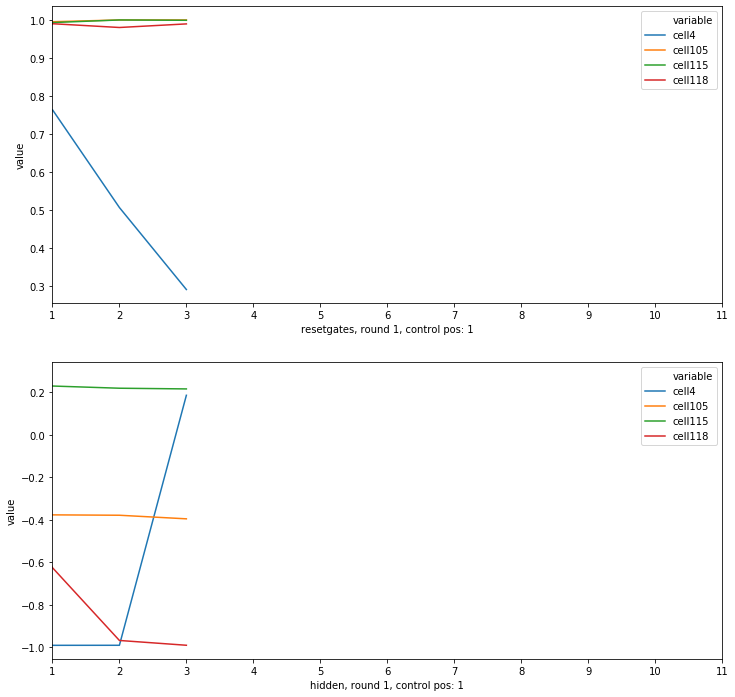

In [402]:
sent_length = 10
plot_types =  ['updategates', 'resetgates', 'newgates', 'hidden']
plot_types =  ['updategates', 'hidden']
plot_types =  ['resetgates', 'hidden']
fig, axes = plt.subplots(len(plot_types), 1, figsize=(12,12))
# ax.set_xlim(1,11)
# ax.set_xticks(range(1,12))
# fig.set_tight_layout(True)
cells_to_show = [3, 104, 114, 117]
# cells_to_show = [24, 36, 59, 82, 73, 53, 6, 39, 97, 44]
anim = FuncAnimation(fig, animate, frames=np.arange(1, sent_length), fargs=(axes,sent_length, cells_to_show,
                                                                            plot_types), interval=10000)

anim.save('group1.gif', writer='imagemagick', fps=6)
HTML(anim.to_jshtml())
HTML(anim.to_html5_video())


# <<<< Animation part done

# >>>> Ablation study part

In [362]:
# certain_set = get_certain_set(7, draw('张朦胧的话只是无聊的暗号'))
certain_set = get_certain_set(7, '看')

In [367]:
import numpy as np

# predictions, gru_info = predict(certain_set, disabled_cells=[3, 6, 24, 28, 36, 104],
#                                 mask_type='Un_h')
predictions, gru_info = predict(certain_set, disabled_cells=[])
# predictions, gru_info = predict(certain_set, disabled_cells=[24, 36, 59, 82, 73, 53, 6, 39, 97, 44])
gates = {'input': gru_info['updategates'].detach().cpu().numpy(),
         'reset': gru_info['resetgates'].detach().cpu().numpy(),
         'new': gru_info['newgates'].detach().cpu().numpy(),
         'hidden': gru_info['hiddens'].detach().cpu().numpy()} # (b,128,s)

gates_avg = {}
gates_std = {}
for key, value in gates.items():
    gates_avg[key] = value.mean(0) # (128,s)
    gates_std[key] = value.std(0) # (128,s)

output_len = gates['input'].shape[2]
print(output_len)

9


In [366]:
untokenize_output(certain_set, predictions)

input:	<SOS>习惯了穿黑色的衬衫其实并没有说特别的喜欢<EOS>7看
pred:	<SOS>我的的的的我看看看得看一<EOS>

input:	<SOS>想象赤脚奔跑在风里<EOS>7看
pred:	<SOS>我的的的的我看看看<SOS><SOS><EOS>

input:	<SOS>亲爱的你<EOS>7看
pred:	<SOS>我我你你你你你看看<EOS>

input:	<SOS>爱你忘了苏醒<EOS>7看
pred:	<SOS>我我你你你你你看看<EOS>

input:	<SOS>她要我她不爱我<EOS>7看
pred:	<SOS>我我你你我你你看看<EOS>

input:	<SOS>资深的高富帅还不成家<EOS>7看
pred:	<SOS>我的的的的我看看看<SOS>一<EOS>

input:	<SOS>说散你想很久了吧<EOS>7看
pred:	<SOS>我我你你你你你看看<EOS>

input:	<SOS>一份爱能承受多少的误解<EOS>7看
pred:	<SOS>我不我我我我你看看得<EOS>

input:	<SOS>只记得装满泪水的眼睛<EOS>7看
pred:	<SOS>我的的的的我看看看<SOS><EOS>

input:	<SOS>我要跟着你一辈子从生一直跟到死<EOS>7看
pred:	<SOS>我我你我我你你看看得好<EOS>

input:	<SOS>你是滴水的沉著你是落花的幽柔<EOS>7看
pred:	<SOS>我的的的我我看看看看看<EOS>

input:	<SOS>其实我早就已经长大<EOS>7看
pred:	<SOS>我的的的我我看看看<SOS><EOS>

input:	<SOS>侬呀侬呀醒醒醒醒<EOS>7看
pred:	<SOS>我们的的的我看看看<SOS><SOS><EOS>

input:	<SOS>我们连道歉都不肯说今天终于知道错<EOS>7看
pred:	<SOS>我我你我我我你看看得得<EOS>

input:	<SOS>捧起星的冠冕戴上<EOS>7看
pred:	<SOS>我的的的的我看看看<SOS><SOS><EOS>

input:	<SOS>若有机会我不会放弃<EOS>7看
pred:	<SOS>我不你我我我你看看得<EOS>



In [368]:
untokenize_output(certain_set, predictions)

input:	<SOS>习惯了穿黑色的衬衫其实并没有说特别的喜欢<EOS>7看
pred:	<SOS>我的的的的你看<EOS>

input:	<SOS>想象赤脚奔跑在风里<EOS>7看
pred:	<SOS>我的的的的你看<EOS>

input:	<SOS>亲爱的你<EOS>7看
pred:	<SOS>我我你你你你看<EOS>

input:	<SOS>爱你忘了苏醒<EOS>7看
pred:	<SOS>我我你你你你看<EOS>

input:	<SOS>她要我她不爱我<EOS>7看
pred:	<SOS>我我你你你你看<EOS>

input:	<SOS>资深的高富帅还不成家<EOS>7看
pred:	<SOS>我的的的的你看<EOS>

input:	<SOS>说散你想很久了吧<EOS>7看
pred:	<SOS>我我你你你你看<EOS>

input:	<SOS>一份爱能承受多少的误解<EOS>7看
pred:	<SOS>我不的我我你看<EOS>

input:	<SOS>只记得装满泪水的眼睛<EOS>7看
pred:	<SOS>我的的的的你看<EOS>

input:	<SOS>我要跟着你一辈子从生一直跟到死<EOS>7看
pred:	<SOS>我我你你你你看<EOS>

input:	<SOS>你是滴水的沉著你是落花的幽柔<EOS>7看
pred:	<SOS>我的的的的你看<EOS>

input:	<SOS>其实我早就已经长大<EOS>7看
pred:	<SOS>我的的的的你看<EOS>

input:	<SOS>侬呀侬呀醒醒醒醒<EOS>7看
pred:	<SOS>我们的的的你看<EOS>

input:	<SOS>我们连道歉都不肯说今天终于知道错<EOS>7看
pred:	<SOS>我我你你你你看<EOS>

input:	<SOS>捧起星的冠冕戴上<EOS>7看
pred:	<SOS>我的的的的你看<EOS>

input:	<SOS>若有机会我不会放弃<EOS>7看
pred:	<SOS>我不你你你你看<EOS>



# <<<< Ablation study part done

In [324]:
certain_set = get_certain_set(7, draw('张朦胧的话只是无聊的暗号'))
# certain_set = get_certain_set(7, '人')

朦


In [325]:
import numpy as np

predictions, gru_info = predict(certain_set)

gates = {'input': gru_info['updategates'].detach().cpu().numpy(),
         'reset': gru_info['resetgates'].detach().cpu().numpy(),
         'new': gru_info['newgates'].detach().cpu().numpy(),
         'hidden': gru_info['hiddens'].detach().cpu().numpy()} # (b,128,s)

gates_avg = {}
gates_std = {}
for key, value in gates.items():
    gates_avg[key] = value.mean(0) # (128,s)
    gates_std[key] = value.std(0) # (128,s)

output_len = gates['input'].shape[2]
print(output_len)

9


In [326]:
untokenize_output(certain_set, predictions)

input:	<SOS>心随你飞<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>比较苛<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>一直有句话要说<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>我的手会记住你的脸<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>今天晚上趁着月光<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>会不会有一片<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>每一个人都是一样<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>完全奉献<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>不理不顾不知决心是对否<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>看你有多大的量<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>甚至是可笑的<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>漂浪水影摇摇荡<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>总是羡慕别人过的生活<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>爱你的心<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>好多关一起闯<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>

input:	<SOS>没送出的信称谓写着谁<EOS>7朦
pred:	<SOS>我的的的的的朦<EOS>



test:----------------------
cells: [4, 7, 10, 15, 18, 19, 24, 47, 50, 57, 60, 62, 67, 68, 77, 82, 96, 116]


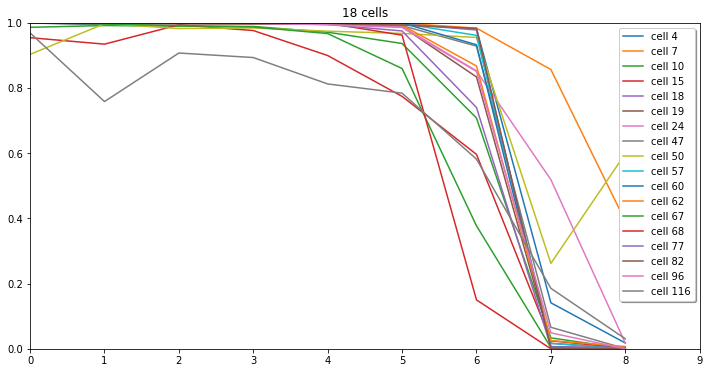

cells: [4, 7, 10, 15, 18, 19, 24, 47, 50, 57, 60, 62, 67, 68, 77, 82, 96, 116]


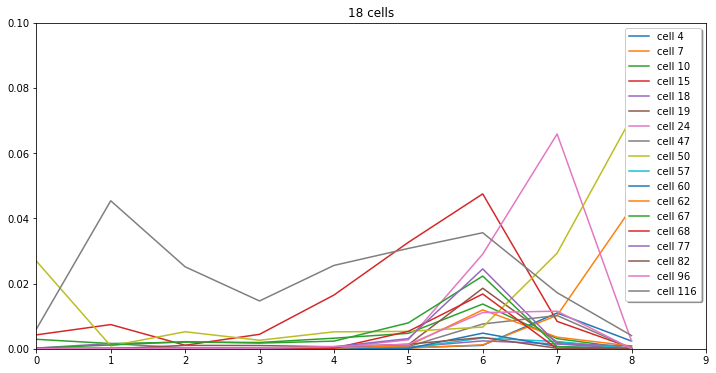

In [327]:
for key, value in cell_types.items():
    print(f'{key}:----------------------')
    plot_cells(gates_avg['input'], include=value, show_legend=True)
    plot_cells(gates_std['input'], include=value, show_legend=True, ylim=(0,0.1))

types: {
'test': {96, 67, 4, 68, 7, 10, 77, 15, 47, 18, 19, 50, 82, 116, 24, 57, 60, 62},
}
cells: [0, 1, 2, 3, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 61, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


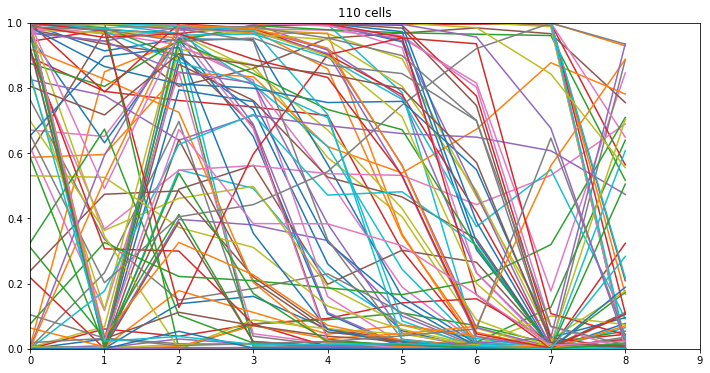

In [38]:
cell_types = {
#     'EOS': {9, 44, 49, 58, 78, 87, 106},
#     'designated': {10, 15, 19, 47, 57, 60, 62, 82},
#     'large': {35, 36, 104},
    'test': {4, 7, 10, 15, 18, 19, 24, 47, 50, 57, 60, 62, 67, 68, 77, 82, 96, 116}
}

# cell_types['xxx10'] = picked

included = set(range(len(gates_avg['input'])))
print('types: {')
for key, value in cell_types.items():
    print(f"'{key}': {value},")
    included -= value
print('}')
plot_cells(gates_avg['input'], include=included)

cells: [9, 16, 44, 49, 58, 78, 80, 87, 95, 103, 106, 122]


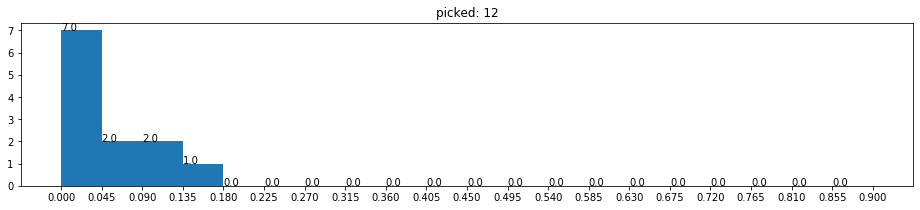

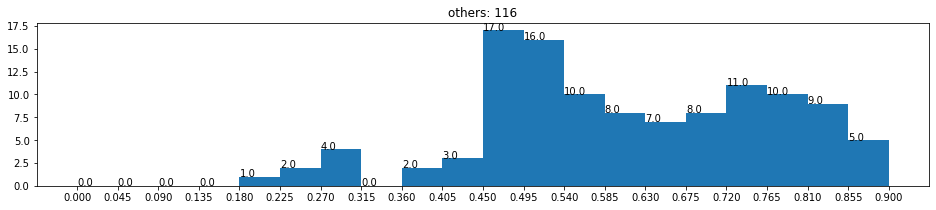

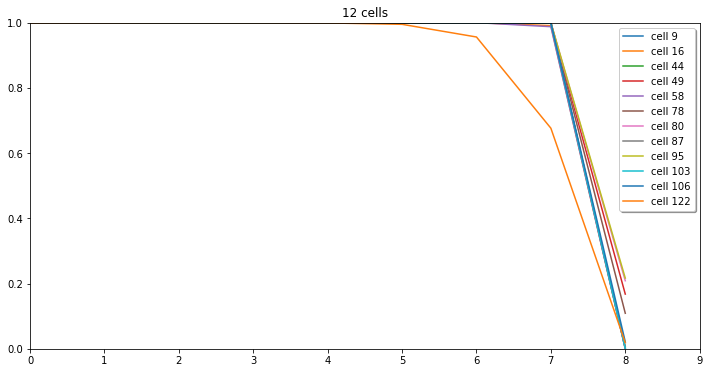

[122, 103, 9, 106, 44, 78, 16, 49, 80, 87, 58, 95]


In [171]:
picked = get_set(gates_avg['input'],
    [1,1,1,1,1,1,1,1,0],
    [1,1,1,1,1,1,1,3,3],
    lambda d: d<0.2,# and d>0.3,
    max_diff=0.9,
#     include=included,
)
print(list(picked))

# >>>> Analysis Part 
## First check: 
1. Input gate: Which neurons activation values goes down from 1 to 0 at index 7.
Once the input gates are turned off, new gate will dominate the h_t.
2. Reset gate: Which neurons activation values goes down from 0 to 1 at index 7.
Once the reset gates are turned on, new gate will dominate the h_t.
## And then:
1. Plot the partial matrices that lead to the changing input_gate/ reset_gate activations at index 7.
2. (TODO)Turn off the activations in the h_(t-1) to see whether the target output characteristic will be ruined.

cells: [4, 10, 18, 19, 47, 57, 60, 62, 77, 82, 89, 91, 92, 96, 125]


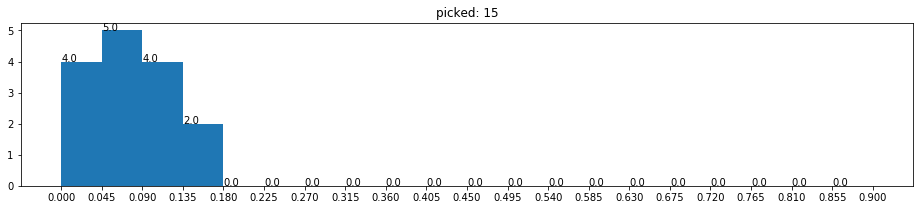

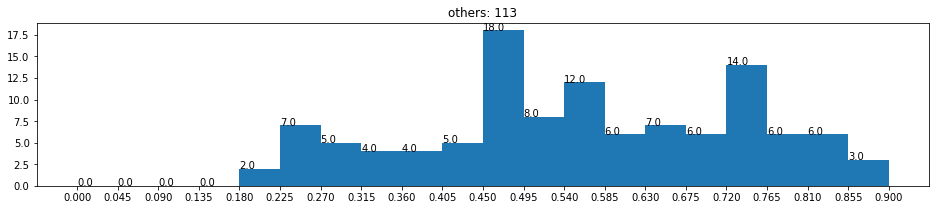

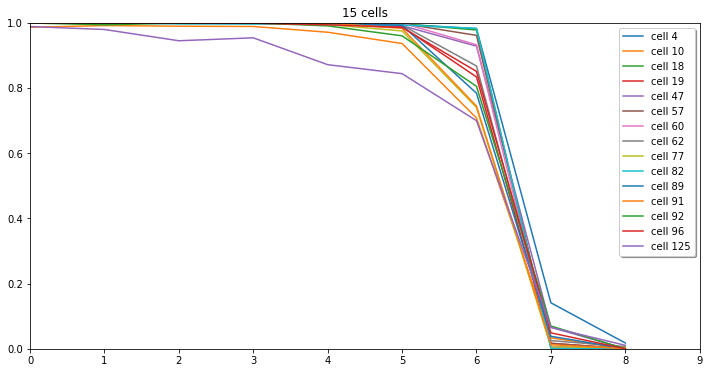

[89, 96, 4, 10, 77, 47, 92, 18, 19, 82, 57, 91, 60, 125, 62]


In [328]:
picked = get_set(gates_avg['input'],
    [1,1,1,1,1,1,1,0,0],
    [1,1,1,1,1,1,3,3,1],
    lambda d: d<0.2,# and d>0.3,
    max_diff=0.9,
#     include=included,
)
print(list(picked))

cells: [16, 54, 55, 66, 71, 75, 89, 94, 107, 108]


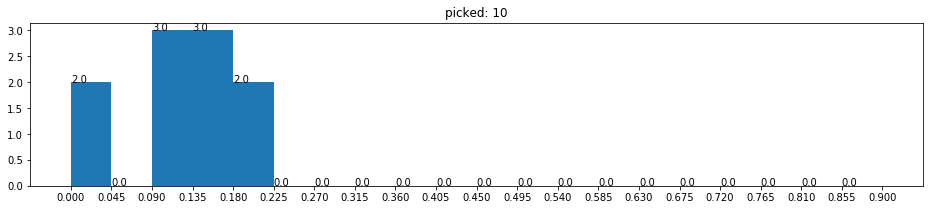

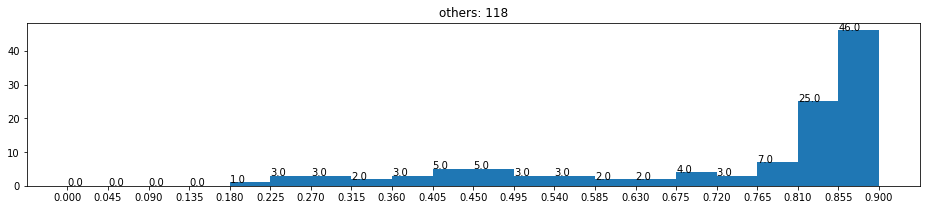

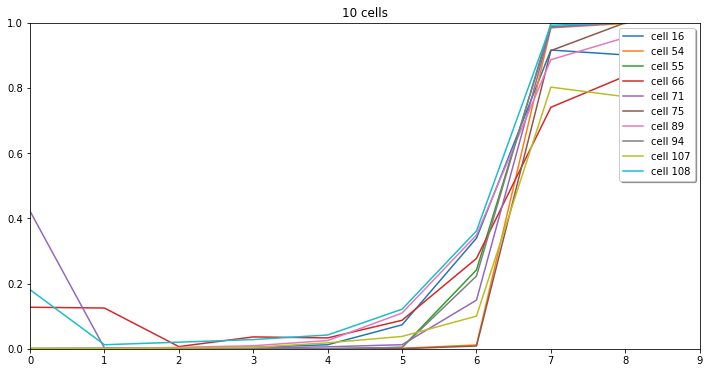

[66, 71, 75, 107, 108, 16, 54, 55, 89, 94]


In [329]:
picked = get_set(gates_avg['reset'],
    [0,0,0,0,0,0,0,1,1],
    [1,1,1,1,1,1,3,3,1],
    lambda d: d<0.2,# and d>0.3,
    max_diff=0.9,
#     include=included,
)
print(list(picked))

In [303]:
picked = get_set(gates_avg['reset'],
    [0,0,0,0,0,0,0,1,1],
    [1,1,1,1,1,1,3,3,1],
    lambda d: d<0.2,# and d>0.3,
    max_diff=0.9,
#     include=included,
)
print(list(picked))

ValueError: operands could not be broadcast together with shapes (15,) (9,) 

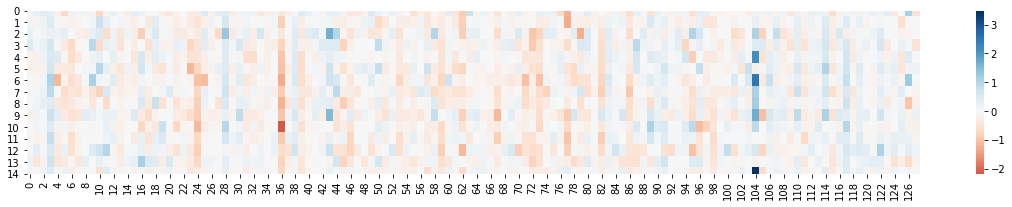

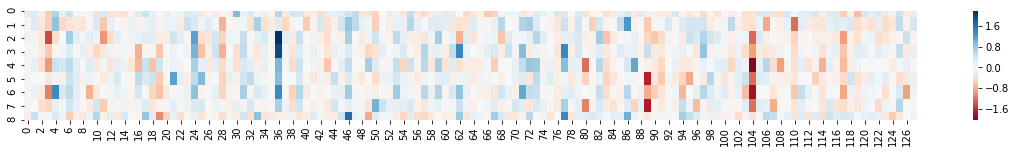

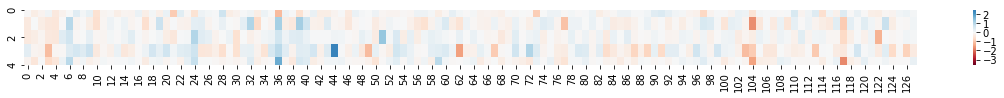

In [372]:

def plot_matrix_by_cell_index(cell_indices, matrix_type='reset', absolute=False):
    assert matrix_type in ['reset', 'input', 'new']
    weights = {'reset':W_hr, 'input':W_hz, 'new':W_hn}
#     for name, W in weights.items():
#         print(name)
    W = weights[matrix_type][cell_indices, :]
    plt.subplots(figsize=(20,1+int(len(cell_indices)*20/128)))
#     plt.subplots()
#     plt.imshow(np.abs(W), cmap='gray')
#     plt.imshow(np.abs(W))
    threshold = 0
    if absolute:
        W = np.abs(W)
        threshold = W.mean()
    g = sns.heatmap(W, center=threshold, vmin=W.min(), vmax=W.max(), 
                    cmap="RdBu",cbar_kws={'label': ""})
#     plt.colorbar()
    plt.show()
plot_matrix_by_cell_index([4, 10, 18, 19, 47, 57, 60, 62, 77, 82, 89, 91, 92, 96, 125], 'input')
plot_matrix_by_cell_index([16, 54, 55, 71, 75, 89, 94, 107, 108], 'reset')
plot_matrix_by_cell_index([3, 6, 24, 28, 36, 104], 'new')

# <<<< Analysis Part done
## Observations:
1. the weights in the input_gate matrix and the ones in the reset_gate matrix seem to be antagonistic (the difference is by *(-1)?!)

average of squared distances of samples to centers: 0.11319441484281953
average of squared distances of centers to centers: 2.4862519763764883
ratio: 21.964440381876344
-----------------------------
group 0: [0.9980228  0.99590325 0.94381285 0.97183275 0.9822517  0.9744463
 0.857029   0.06834266 0.00628273]
cells: [4, 10, 18, 19, 24, 47, 57, 60, 62, 77, 82, 89, 91, 92, 96, 100, 125]


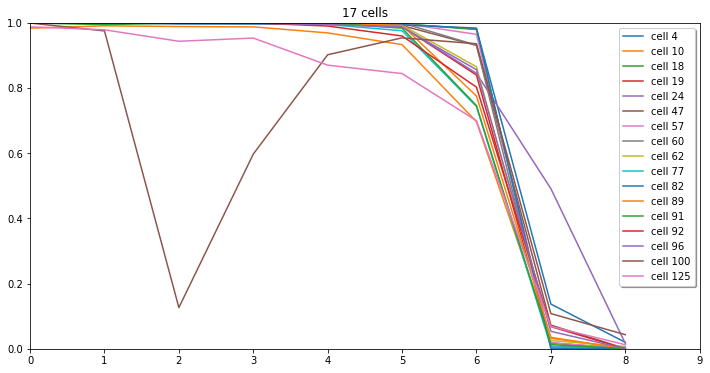

-----------------------------
group 1: [0.9807527  0.94182104 0.9735674  0.9667345  0.93450576 0.8539753
 0.3583849  0.0513535  0.01449306]
cells: [5, 15, 25, 36, 48, 52, 67, 68, 73, 74, 81, 86, 90, 97, 110, 115, 116, 123]


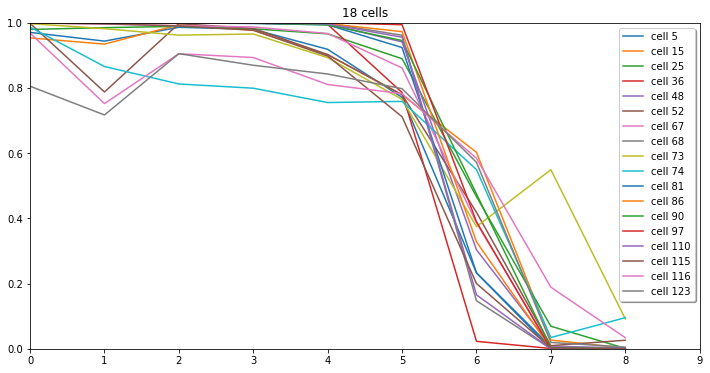

-----------------------------
group 2: [0.900743   0.20904675 0.1318177  0.07635468 0.05211651 0.03366914
 0.01208502 0.01235837 0.06154084]
cells: [2, 29, 34, 64, 65, 84, 102, 108, 112, 127]


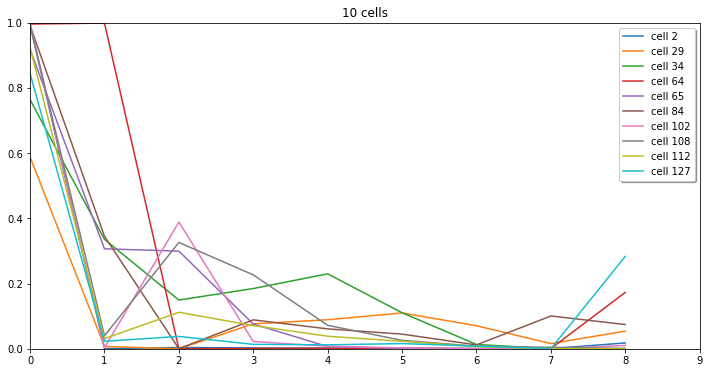

-----------------------------
group 3: [0.80781776 0.95460343 0.9572829  0.9776684  0.98568094 0.9830941
 0.9646344  0.7859665  0.6506834 ]
cells: [1, 7, 22, 30, 32, 50, 51, 70, 126]


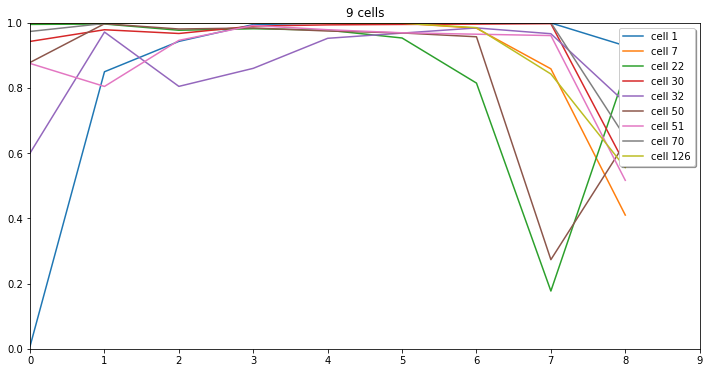

-----------------------------
group 4: [0.06132174 0.01532739 0.15959007 0.08374703 0.0530166  0.03444773
 0.02259144 0.05626889 0.06266312]
cells: [13, 17, 31, 40, 56, 63, 69, 71, 79, 99, 114, 118]


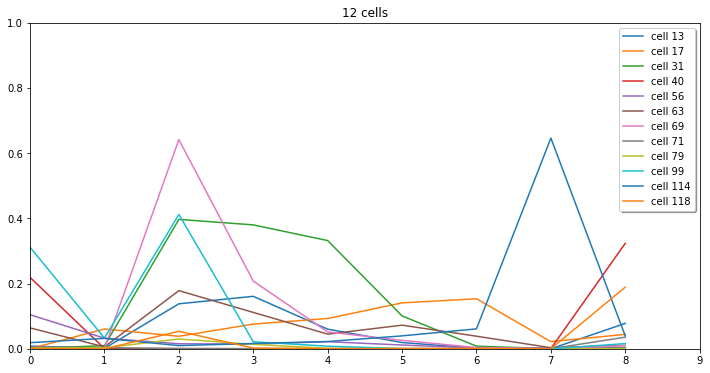

-----------------------------
group 5: [0.95190006 0.9024655  0.94302374 0.8899019  0.7356567  0.29363364
 0.02697206 0.00191103 0.01178063]
cells: [3, 8, 14, 20, 28, 37, 45, 46, 59, 117, 121]


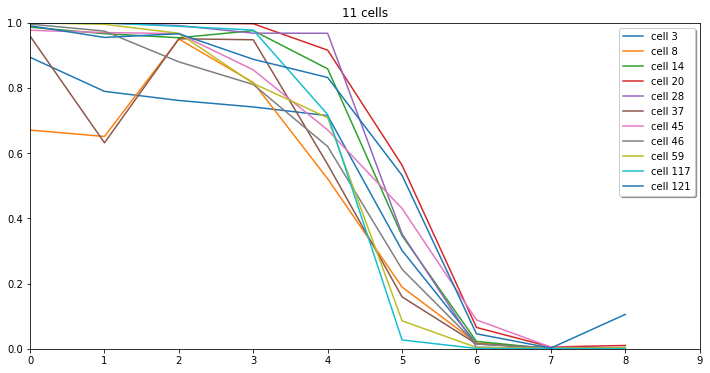

-----------------------------
group 6: [0.917537   0.02660215 0.67498183 0.2763415  0.14069808 0.11917964
 0.07829374 0.00397    0.02052519]
cells: [12, 21, 26, 55, 120, 124]


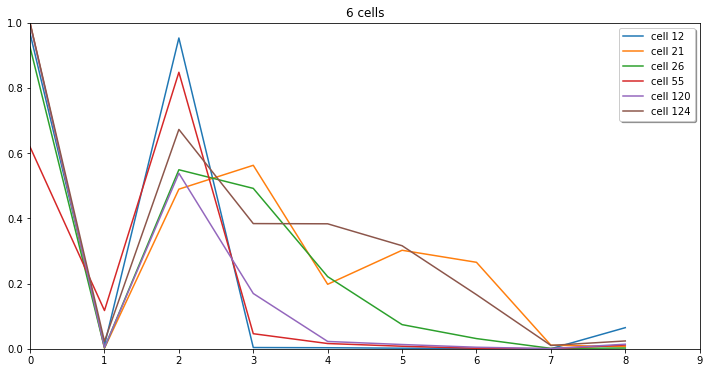

-----------------------------
group 7: [1.7159581e-03 5.5578911e-01 9.8727703e-01 9.7741044e-01 9.1359878e-01
 5.4507947e-01 4.4069588e-02 4.6671927e-04 3.5423204e-02]
cells: [101, 119]


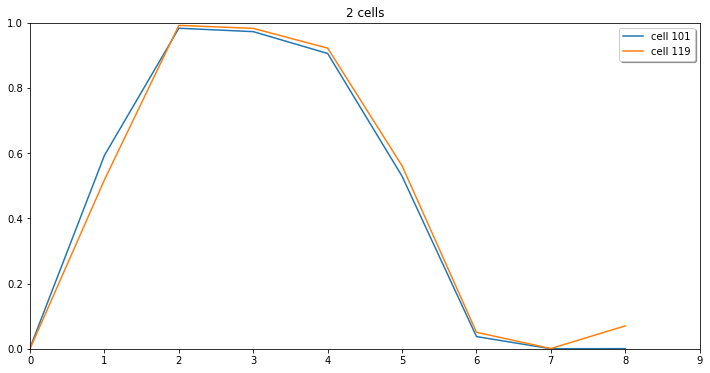

-----------------------------
group 8: [0.9486481  0.8949785  0.91184556 0.5846487  0.12347969 0.01471564
 0.00413245 0.0143249  0.06877925]
cells: [0, 6, 33, 39, 41, 53, 75, 83, 107, 113]


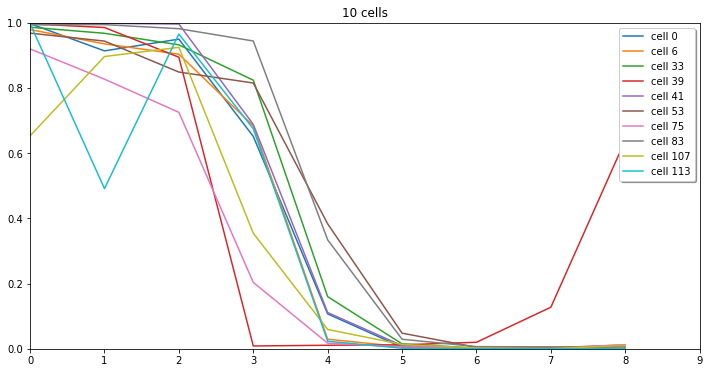

-----------------------------
group 9: [0.9999131  0.9999442  0.9999877  0.99996346 0.9999236  0.999568
 0.99631035 0.9709507  0.06291863]
cells: [9, 16, 44, 49, 58, 78, 80, 87, 95, 103, 106, 122]


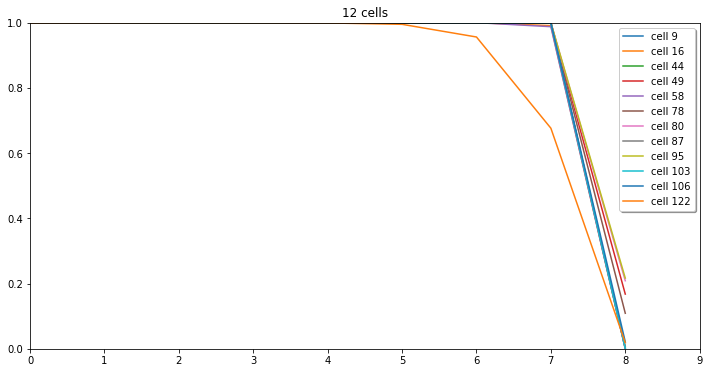

-----------------------------
group 10: [0.01709497 0.11249405 0.18835217 0.06704849 0.04768109 0.04605544
 0.05961922 0.18602394 0.82417727]
cells: [23, 76, 98, 105, 111]


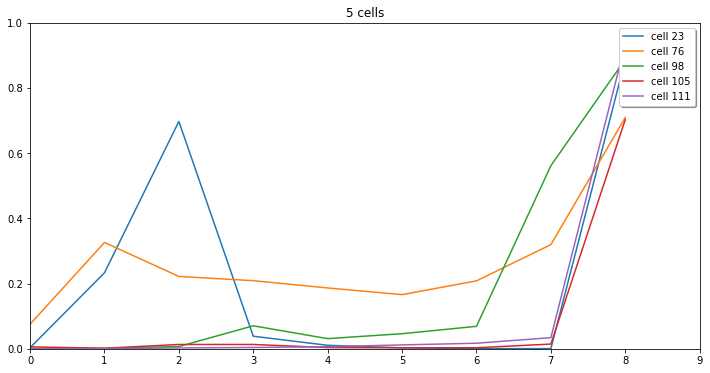

-----------------------------
group 11: [0.4482751  0.5090631  0.35504234 0.26168847 0.0967173  0.0403432
 0.00756434 0.00274529 0.18542898]
cells: [35, 54, 94, 109]


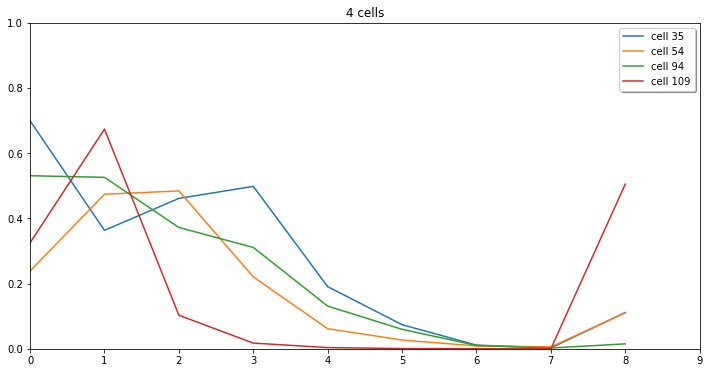

-----------------------------
group 12: [0.9980228  0.99590325 0.94381285 0.97183275 0.9822517  0.9744463
 0.857029   0.06834266 0.00628273]
cells: [4, 10, 18, 19, 24, 47, 57, 60, 62, 77, 82, 89, 91, 92, 96, 100, 125]


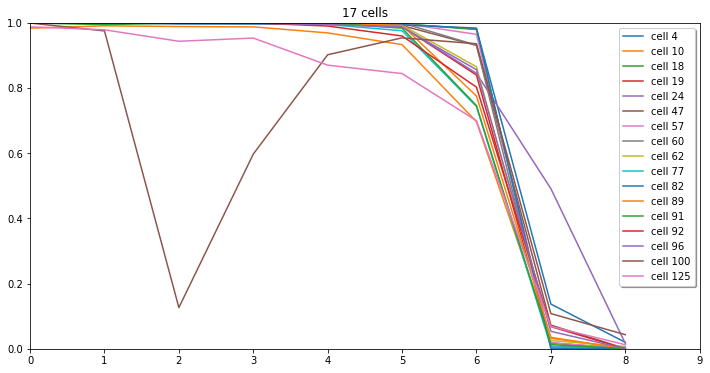

-----------------------------
group 13: [1.4265180e-03 6.8944454e-02 8.0858630e-01 7.7026480e-01 4.1107893e-01
 2.6966432e-01 9.7188652e-02 5.1468611e-04 1.6065979e-01]
cells: [11, 27, 61, 85]


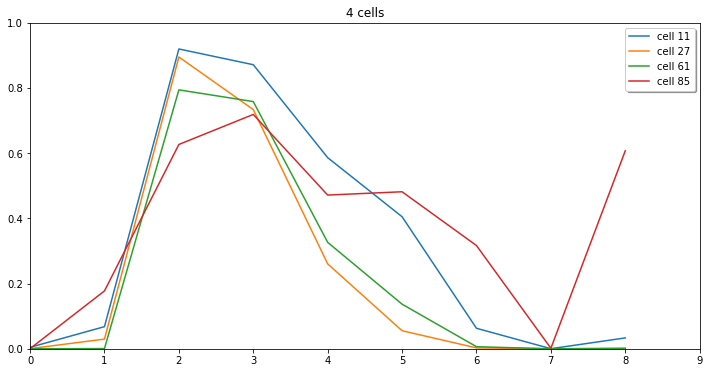

-----------------------------
group 14: [0.7417815  0.48543522 0.60965806 0.6384822  0.5959382  0.61952007
 0.6712213  0.7536484  0.71952474]
cells: [38, 43, 66, 104]


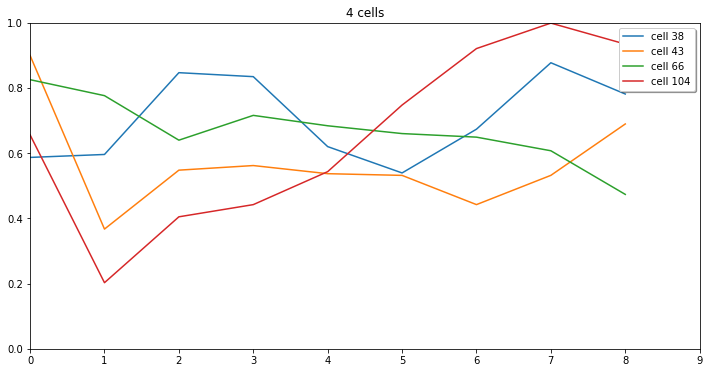

In [175]:
analyze_cells(gates_avg['input'], 15)

average of squared distances of samples to centers: 0.09564923453805016
average of squared distances of centers to centers: 2.867582775297619
ratio: 29.98019575532377
-----------------------------
group 0: [0.06755358 0.00214177 0.00365692 0.00557381 0.01181465 0.0400818
 0.19744927 0.9386176  0.95451236]
cells: [16, 54, 55, 71, 75, 89, 94, 107, 108]


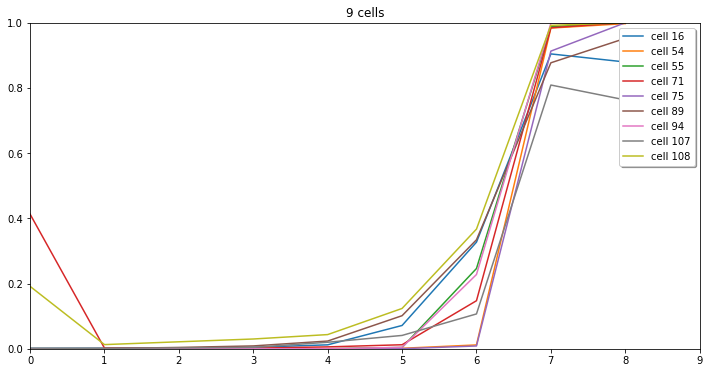

-----------------------------
group 1: [0.01468724 0.01300257 0.00915486 0.0065046  0.04533052 0.14770657
 0.8240155  0.99828535 0.9487484 ]
cells: [3, 23, 82, 104]


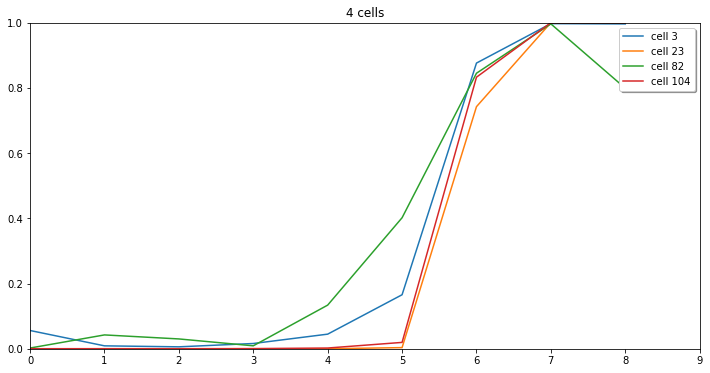

-----------------------------
group 2: [0.07727301 0.06220943 0.01809096 0.0175603  0.02941465 0.04622275
 0.08477271 0.3637027  0.6884997 ]
cells: [7, 66, 69, 72, 76, 101, 103, 125]


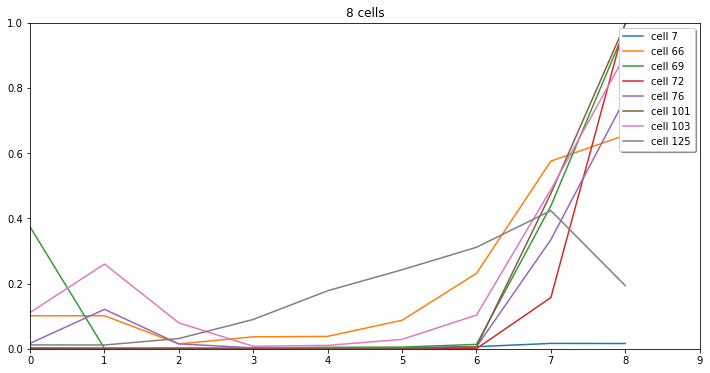

-----------------------------
group 3: [0.9945092  0.99424607 0.9896102  0.9908528  0.9954572  0.99410844
 0.98934454 0.9711026  0.09796444]
cells: [0, 4, 8, 10, 11, 13, 14, 17, 18, 19, 20, 21, 27, 29, 34, 38, 41, 42, 43, 45, 46, 47, 48, 49, 50, 56, 57, 59, 60, 62, 65, 74, 77, 80, 81, 86, 88, 90, 92, 93, 97, 100, 102, 109, 110, 112, 113, 115, 119, 120, 121, 124, 126, 127]


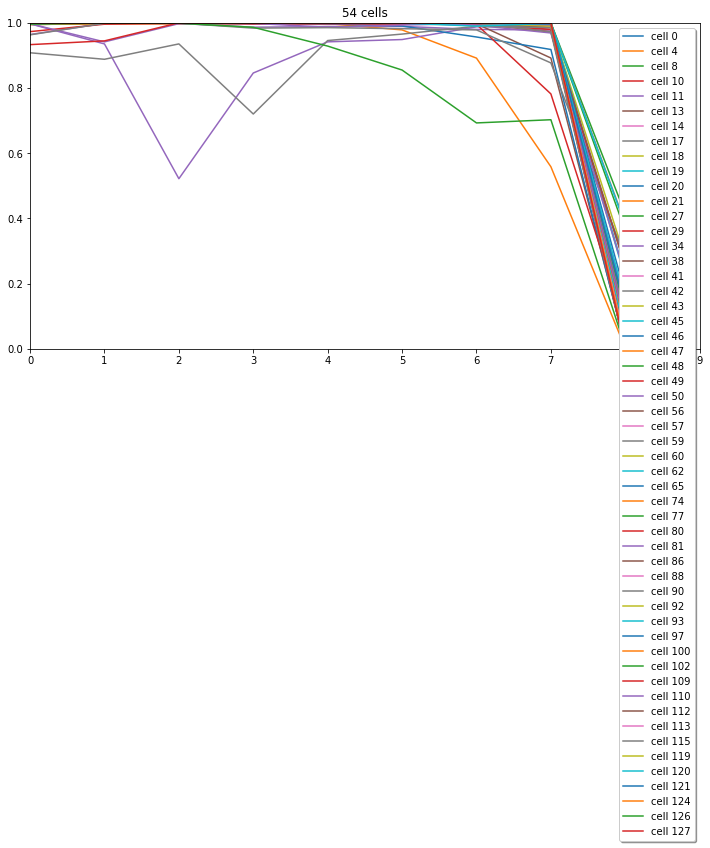

-----------------------------
group 4: [0.41716677 0.46438292 0.48662484 0.46819508 0.31660634 0.48707527
 0.71425015 0.9278265  0.9616636 ]
cells: [1, 24]


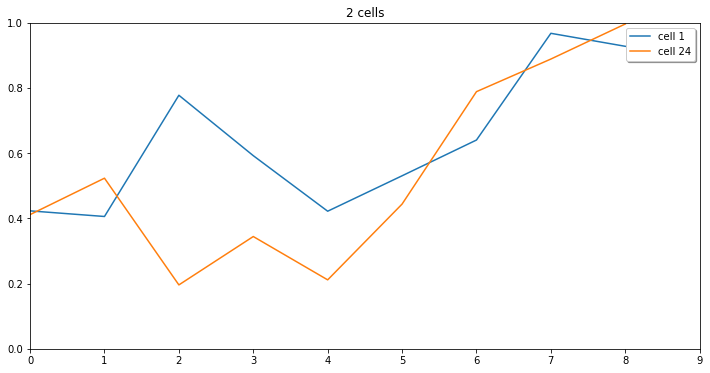

-----------------------------
group 5: [0.06755358 0.00214177 0.00365692 0.00557381 0.01181465 0.0400818
 0.19744927 0.9386176  0.95451236]
cells: [16, 54, 55, 71, 75, 89, 94, 107, 108]


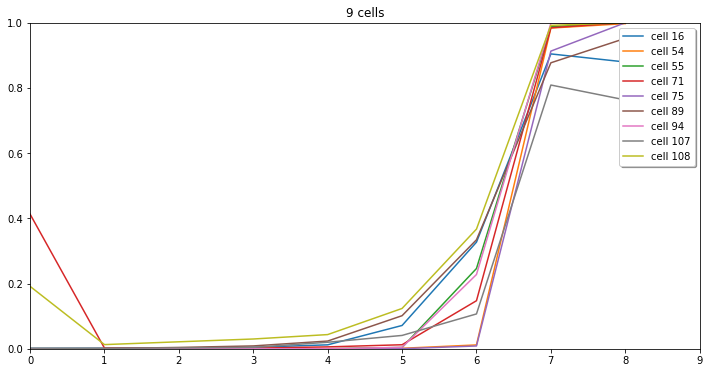

-----------------------------
group 6: [0.15862942 0.3765633  0.75898224 0.6351682  0.4980335  0.3187933
 0.30635828 0.3265707  0.4689865 ]
cells: [30, 64, 70, 122]


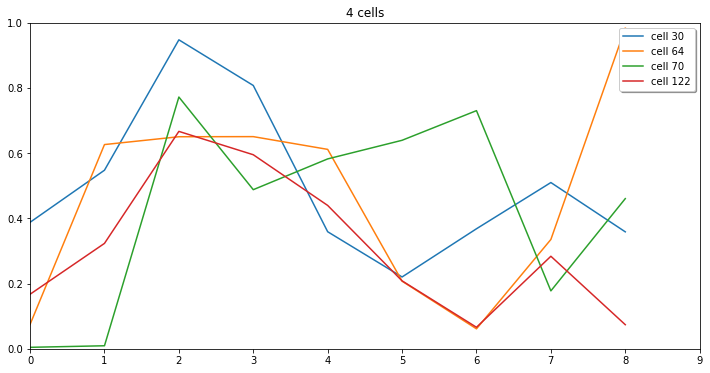

-----------------------------
group 7: [0.9531756  0.9785447  0.49066204 0.05341357 0.07542926 0.11744213
 0.13380367 0.93825483 0.898134  ]
cells: [2, 87]


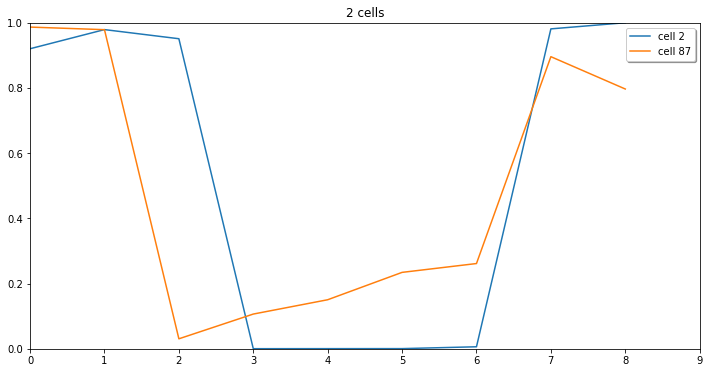

-----------------------------
group 8: [0.95475405 0.98313046 0.9603209  0.96400976 0.98281527 0.9864652
 0.98465115 0.98355544 0.76980877]
cells: [5, 6, 12, 15, 22, 25, 26, 28, 33, 35, 39, 44, 52, 63, 67, 73, 79, 85, 91, 96, 99, 106, 111, 123]


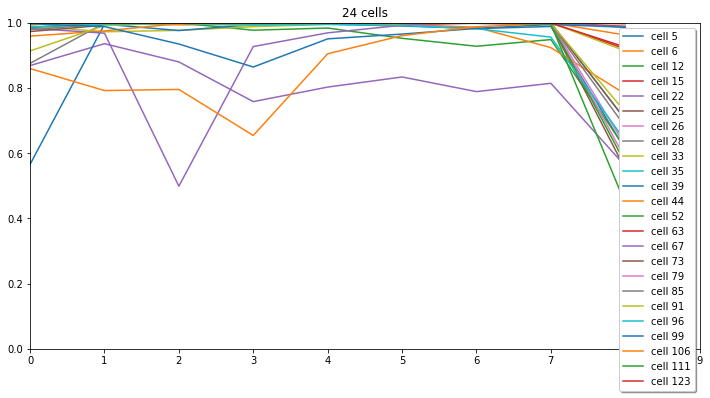

-----------------------------
group 9: [0.9761206  0.99783874 0.99729466 0.9916861  0.9823659  0.84899986
 0.36510435 0.02875495 0.36532426]
cells: [40, 83]


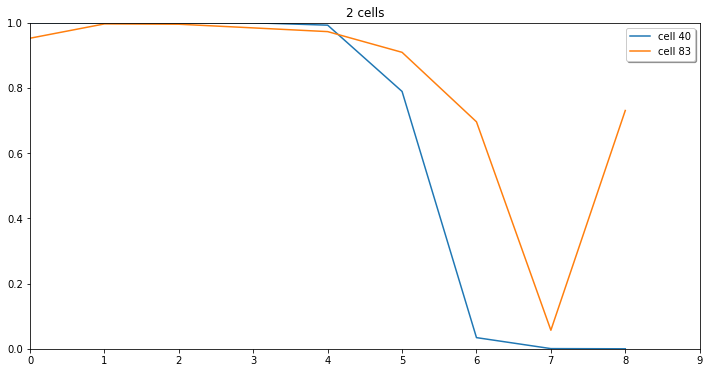

-----------------------------
group 10: [0.14081162 0.593047   0.69135237 0.07073933 0.12676197 0.25007984
 0.5230098  0.7902673  0.6071502 ]
cells: [9, 51, 95]


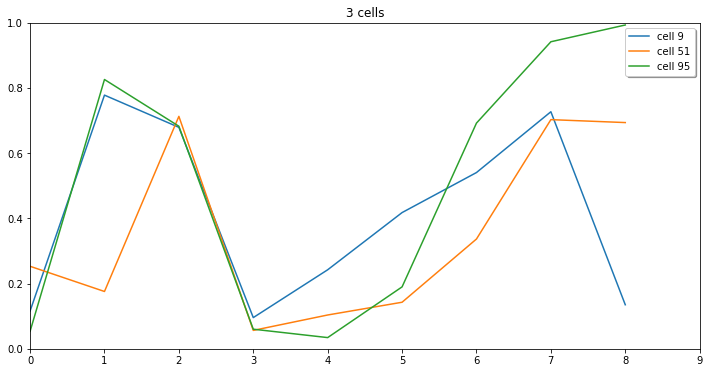

-----------------------------
group 11: [0.12623519 0.48934802 0.79803795 0.81018484 0.91387284 0.962433
 0.98573804 0.9830927  0.90381145]
cells: [37, 58, 68, 116, 117]


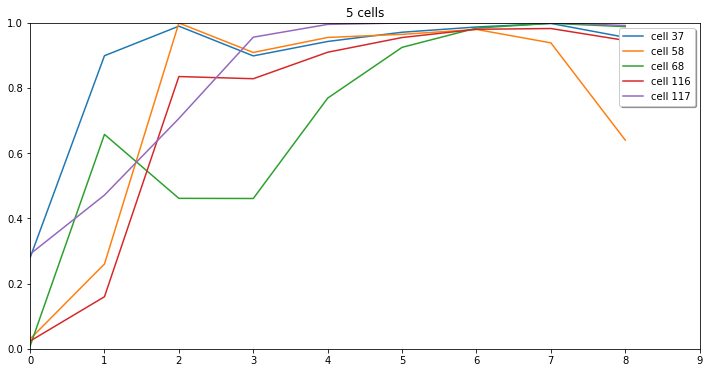

-----------------------------
group 12: [0.37133327 0.06786132 0.07574189 0.16133118 0.42722857 0.8546975
 0.97189283 0.9795406  0.8345813 ]
cells: [31, 36, 78, 98, 114]


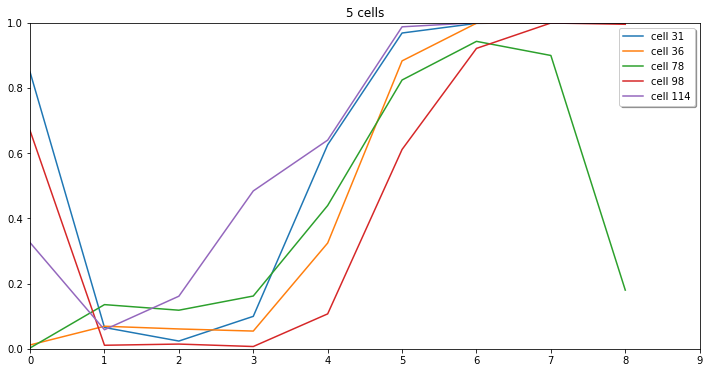

-----------------------------
group 13: [0.99754995 0.9998216  0.88911164 0.7351258  0.27365142 0.04328096
 0.00766701 0.01615775 0.00109068]
cells: [84]


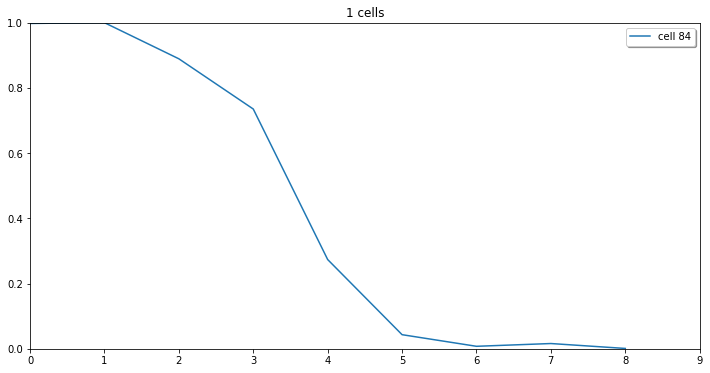

-----------------------------
group 14: [0.7858824  0.07751054 0.17778283 0.01681602 0.0388788  0.0910117
 0.2311151  0.93333733 0.8220978 ]
cells: [32, 61, 105, 118]


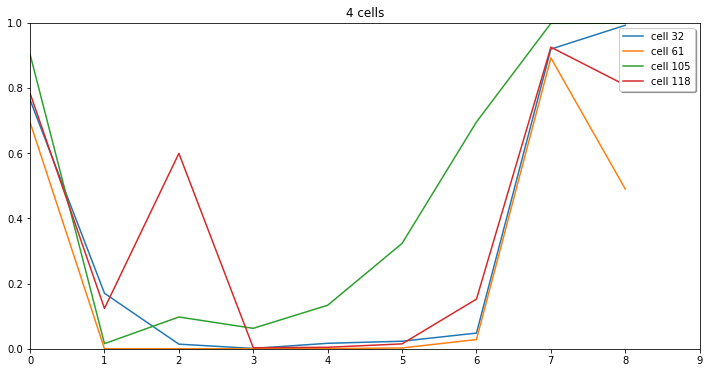

In [41]:
analyze_cells(gates_avg['reset'], 15)

average of squared distances of samples to centers: 0.6964656674202842
average of squared distances of centers to centers: 9.900095331101191
ratio: 14.214764336871399
-----------------------------
group 0: [ 0.7962951   0.88483393  0.9336568   0.98292863  0.9813049   0.98937804
  0.9950014   0.8716661  -0.1034039 ]
cells: [21, 33, 46, 50, 53, 57, 58, 59, 62, 113, 121, 124, 125]


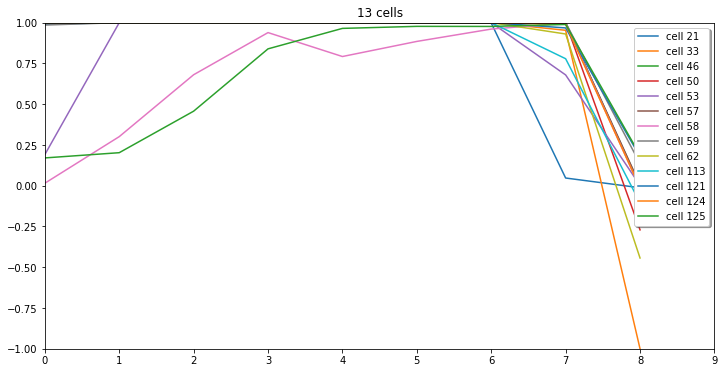

-----------------------------
group 1: [0.9889613  0.9987507  0.99834347 0.9969764  0.99818873 0.99755555
 0.9935929  0.98987705 0.9011068 ]
cells: [5, 6, 39, 42, 52, 63, 73, 77, 96]


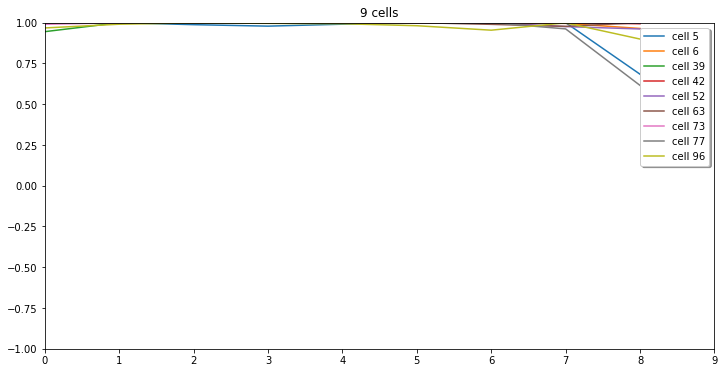

-----------------------------
group 2: [-0.990437   -0.9896953  -0.9026106  -0.9573608  -0.8696118  -0.62202615
  0.6036658   0.99752134  0.78170794]
cells: [17, 24, 26, 56, 79, 106]


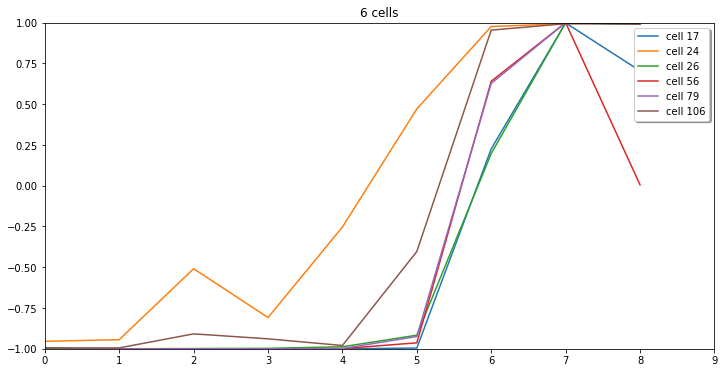

-----------------------------
group 3: [-0.7777933  -0.578619   -0.9101702  -0.29999202  0.1246217   0.18176886
 -0.11226002 -0.33212602  0.08813702]
cells: [30, 49]


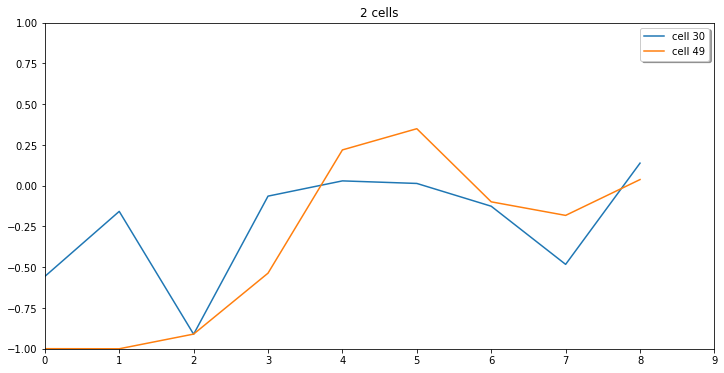

-----------------------------
group 4: [ 0.01690165 -0.17728537 -0.05347473 -0.01781774  0.02899311  0.10811675
  0.36666077  0.761849    0.77934414]
cells: [7, 16, 23, 36, 51, 55, 71, 76, 87, 103, 107, 108]


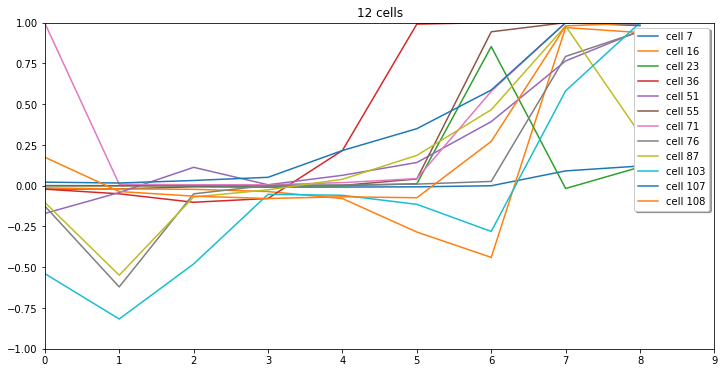

-----------------------------
group 5: [ 0.84642303  0.927274    0.9693097   0.97994626  0.9800955   0.96389025
  0.42177576 -0.76353264 -0.67863476]
cells: [4, 8, 10, 11, 14, 43, 67, 68, 86, 88, 90, 91, 114]


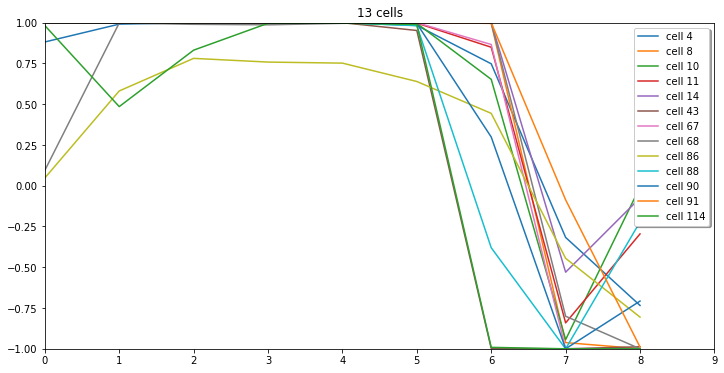

-----------------------------
group 6: [-0.34580347  0.66872716  0.7985894   0.77516025  0.8137406   0.6143706
 -0.07112041  0.10821796  0.02325402]
cells: [40, 78, 122]


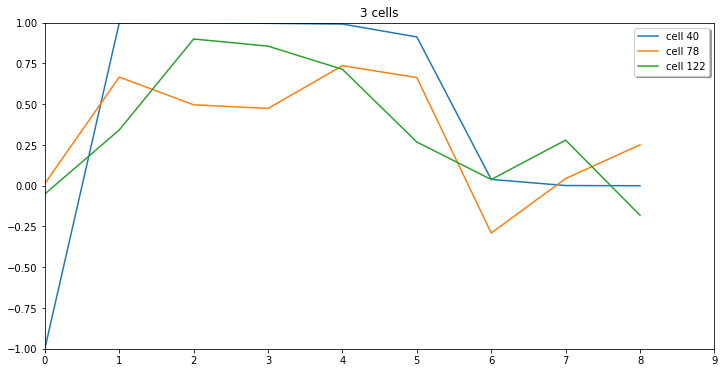

-----------------------------
group 7: [ 0.12069071  0.29520434  0.01615487 -0.06398728 -0.03982155 -0.1979956
 -0.6727755  -0.9323821  -0.94323194]
cells: [3, 54, 66, 80, 94, 95, 104]


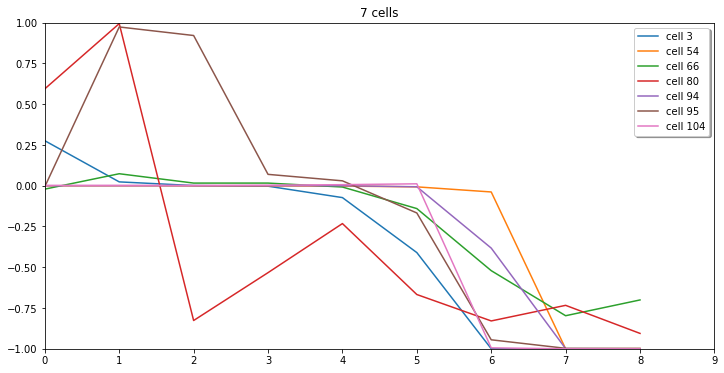

-----------------------------
group 8: [-0.75471723 -0.8452524  -0.86127305 -0.9544656  -0.9945602  -0.9809942
 -0.96191233 -0.9138515  -0.19361433]
cells: [0, 20, 25, 27, 28, 34, 35, 37, 41, 47, 60, 64, 74, 82, 83, 93, 100, 109, 116, 117, 119, 126]


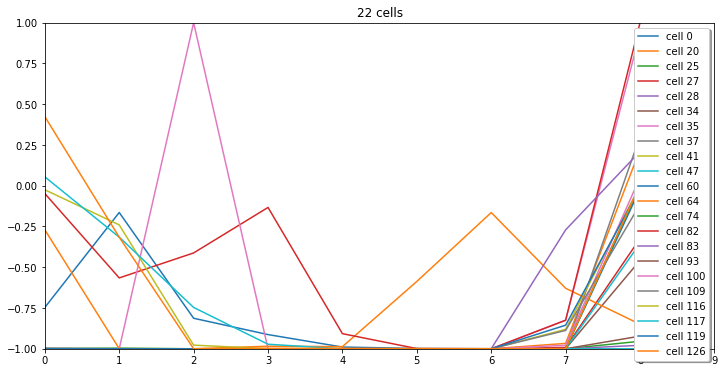

-----------------------------
group 9: [ 0.7644852  -0.08686625 -0.6863771  -0.5059487  -0.6748658  -0.7495078
 -0.65811527  0.37743658  0.22142133]
cells: [9, 13, 70, 98, 105, 110]


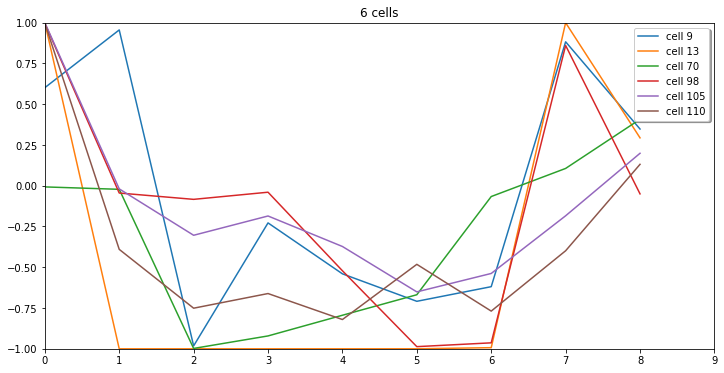

-----------------------------
group 10: [-0.97220033  0.9573308  -0.9810654  -0.9730005  -0.9182881  -0.80090004
 -0.7290375  -0.24770527  0.19288923]
cells: [29, 44, 84, 112]


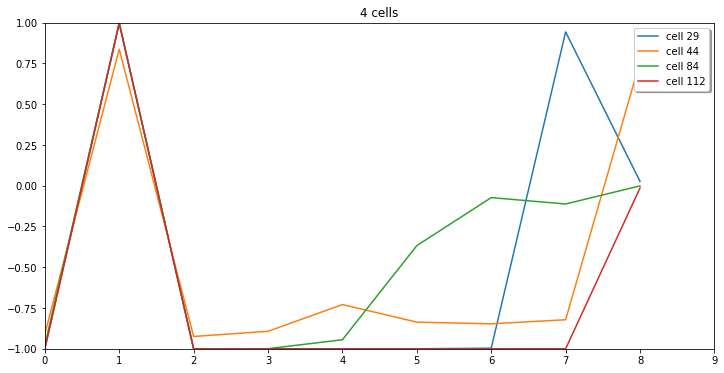

-----------------------------
group 11: [-0.48119974 -0.99587655  0.99123514  0.9992949   0.9974929   0.9898619
  0.93774027  0.21384254  0.25803515]
cells: [12, 38, 127]


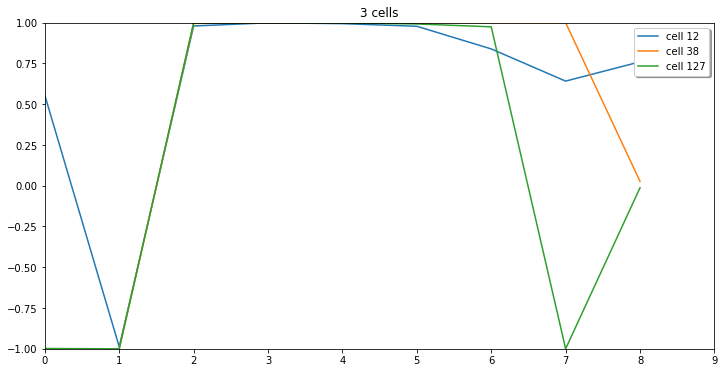

-----------------------------
group 12: [ 2.8285623e-01 -3.0559653e-01  1.4595398e-01 -4.6312064e-04
  5.0512217e-02  5.9904747e-02 -1.8789079e-02  6.5351719e-01
 -8.8814783e-01]
cells: [2, 15, 32, 72, 89, 101]


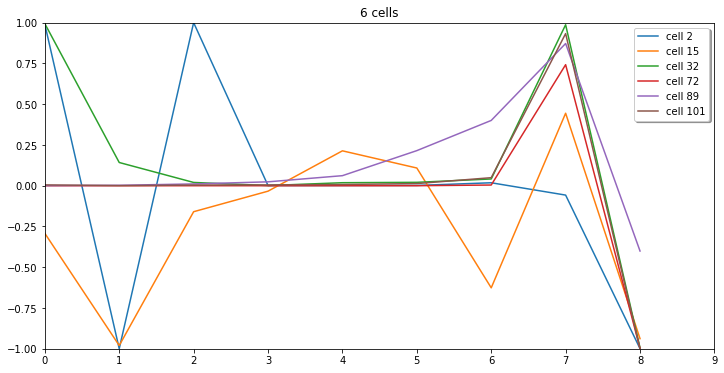

-----------------------------
group 13: [-0.9940892  -0.9680263  -0.9512175  -0.974066   -0.99948686 -0.9975121
 -0.8667405   0.7109485   0.660434  ]
cells: [18, 19, 22, 31, 45, 48, 65, 81, 85, 92, 97, 99, 102, 111, 115, 120, 123]


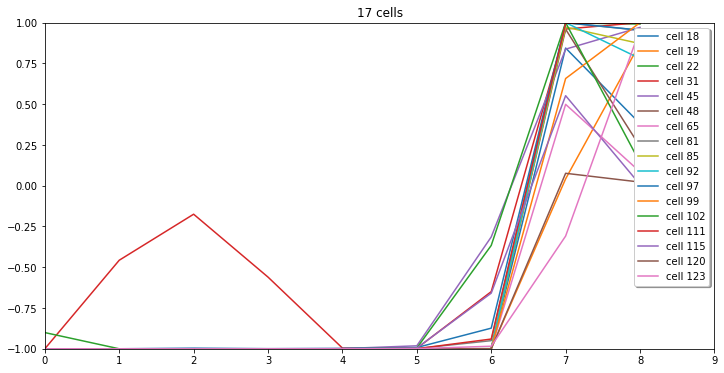

-----------------------------
group 14: [-0.56323826  0.19933191  0.16901174 -0.10563082  0.01407512  0.04648225
 -0.01798963 -0.6974061   0.9752984 ]
cells: [1, 61, 69, 75, 118]


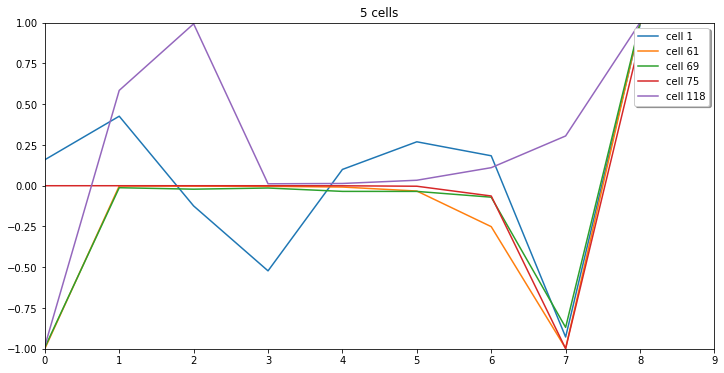

In [42]:
analyze_cells(gates_avg['new'], 15, ylim=(-1,1))

average of squared distances of samples to centers: 0.8095208949443768
average of squared distances of centers to centers: 8.871856398809523
ratio: 10.95939147984453
-----------------------------
group 0: [-0.1491302   0.1344191   0.15567605  0.05582547  0.04072213  0.02650706
  0.04198594 -0.11091374  0.4970001 ]
cells: [1, 19, 23, 30, 61, 69, 78, 87, 104, 118, 123]


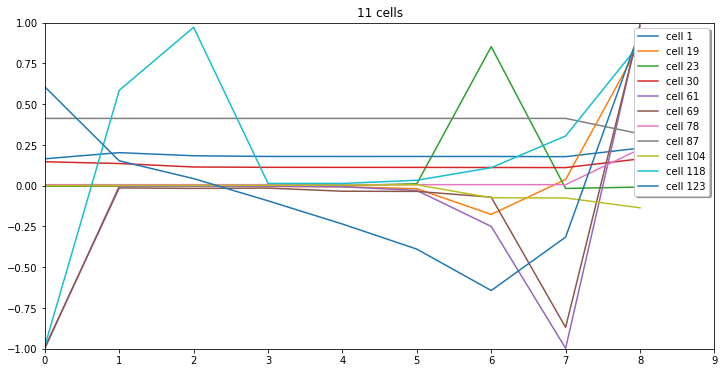

-----------------------------
group 1: [-0.03157513 -0.17152327 -0.13912585 -0.10196376 -0.07526504 -0.04538777
  0.23587182  0.9230839   0.80392486]
cells: [18, 36, 45, 55, 71, 76, 77, 96, 97, 107, 108, 125]


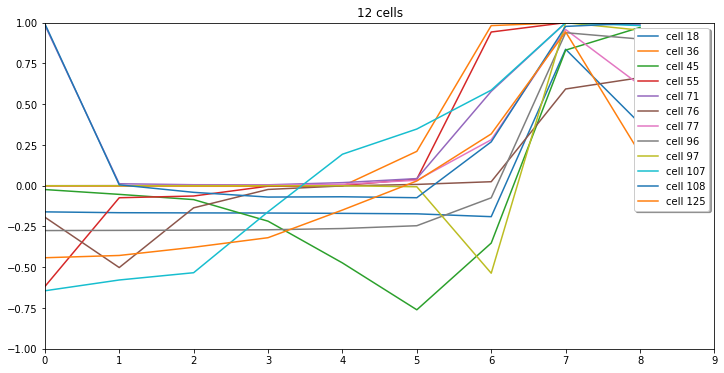

-----------------------------
group 2: [-0.00405484 -0.18387441  0.10667114 -0.03093439 -0.02915988 -0.02355839
  0.02773864  0.60751456 -0.5441016 ]
cells: [2, 32, 57, 62, 72, 89, 101]


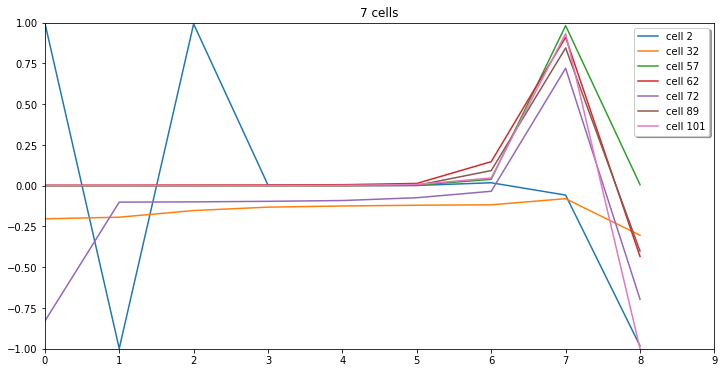

-----------------------------
group 3: [-0.99855864 -0.94988525 -0.9339942  -0.94931734 -0.9820384  -0.9950377
 -0.90464634  0.7443774   0.69198513]
cells: [22, 24, 31, 48, 65, 81, 85, 92, 99, 111, 115]


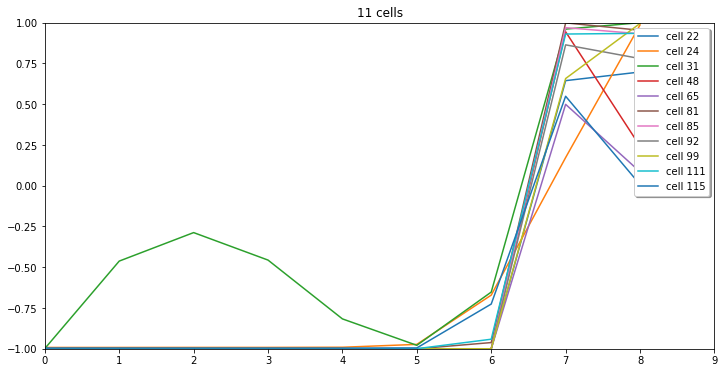

-----------------------------
group 4: [ 0.72488534  0.645299    0.54130626  0.32228136  0.26595402  0.2627115
  0.18011692 -0.99385613  0.42448276]
cells: [60, 75]


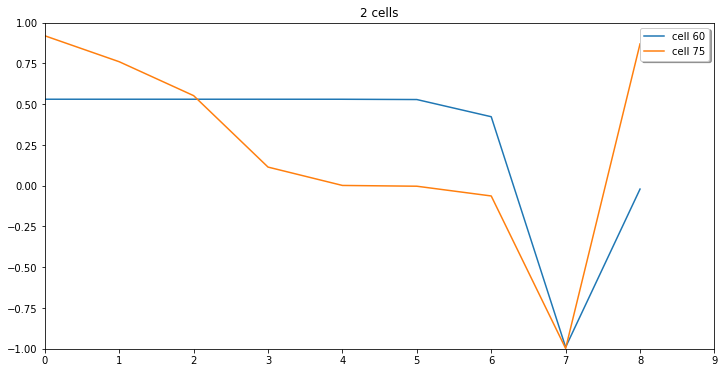

-----------------------------
group 5: [-0.10631907 -0.0923309   0.09474452  0.0045421  -0.00664662 -0.07199209
 -0.05125292 -0.9435949  -0.7410014 ]
cells: [10, 25, 28, 54, 67, 68, 94, 100]


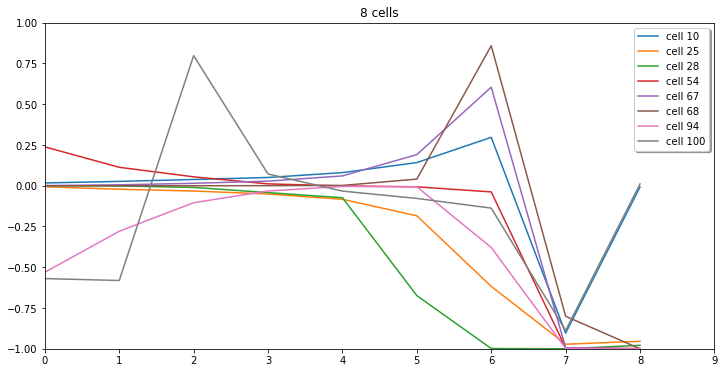

-----------------------------
group 6: [ 0.9903352   0.19378693 -0.6674497  -0.63394344 -0.75443    -0.71165335
 -0.5433763  -0.41772527 -0.39194983]
cells: [64, 84, 93, 98, 105]


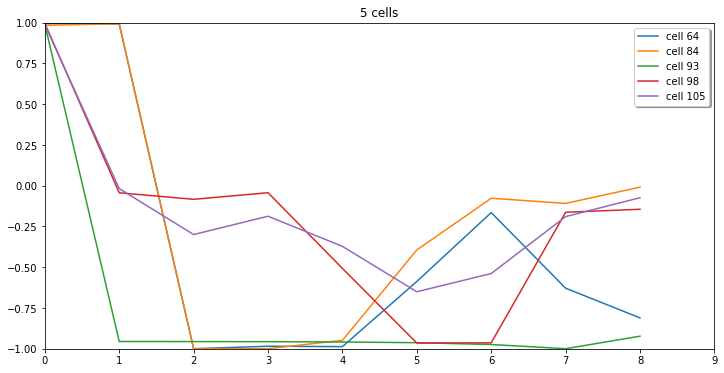

-----------------------------
group 7: [-0.9881866  -0.9645549  -0.94766605 -0.9305021  -0.8724907  -0.7173277
  0.45086315  0.95246685  0.7284008 ]
cells: [5, 17, 26, 56, 73, 79]


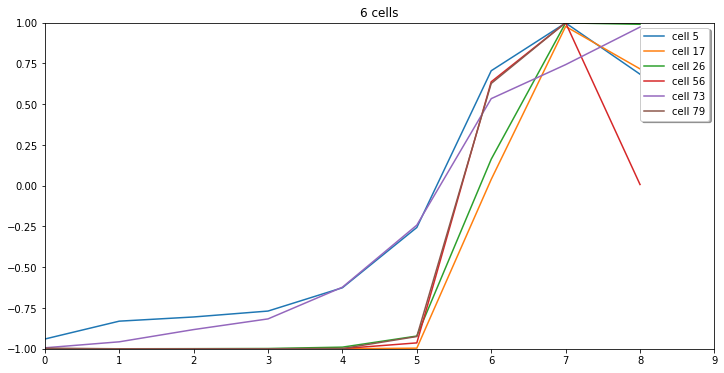

-----------------------------
group 8: [ 0.8832288   0.7522002   0.9735887   0.99758446  0.9975614   0.98674715
  0.40163687 -0.7242592  -0.51296985]
cells: [8, 11, 14, 43, 88, 90, 91, 110, 114, 127]


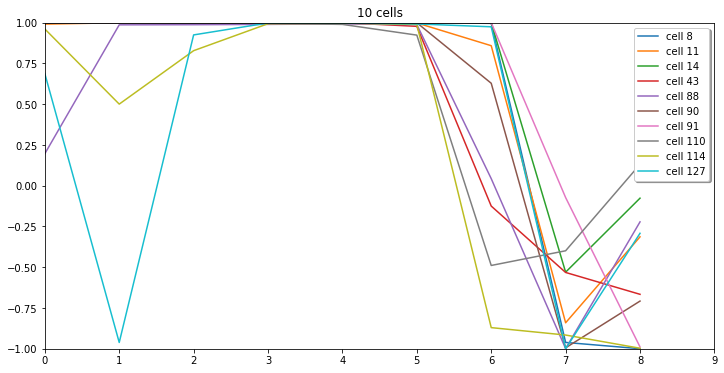

-----------------------------
group 9: [-0.9325414  -0.8445432  -0.92227834 -0.93096024 -0.93130565 -0.9287288
 -0.88599724 -0.8235027   0.00515082]
cells: [0, 4, 7, 9, 20, 27, 34, 35, 37, 41, 44, 47, 49, 58, 70, 82, 86, 103, 109, 112, 119, 122]


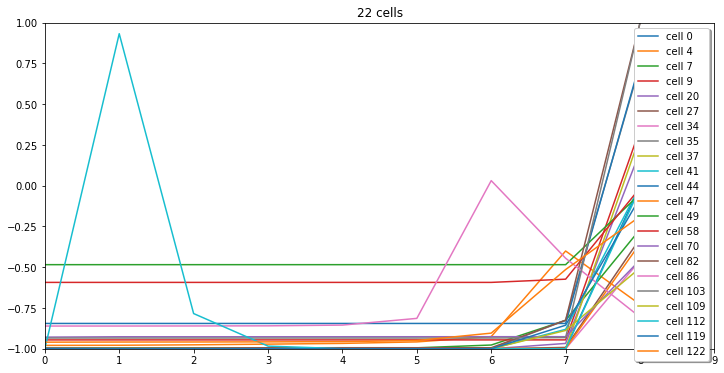

-----------------------------
group 10: [0.84593487 0.82996756 0.826911   0.8264905  0.8255871  0.82426894
 0.8201814  0.76541126 0.38645452]
cells: [16, 51, 52, 63, 80, 95, 106, 113, 121, 126]


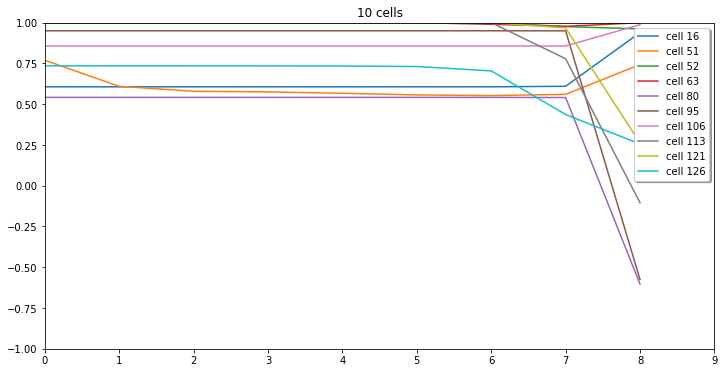

-----------------------------
group 11: [-0.1491302   0.1344191   0.15567605  0.05582547  0.04072213  0.02650706
  0.04198594 -0.11091374  0.4970001 ]
cells: [1, 19, 23, 30, 61, 69, 78, 87, 104, 118, 123]


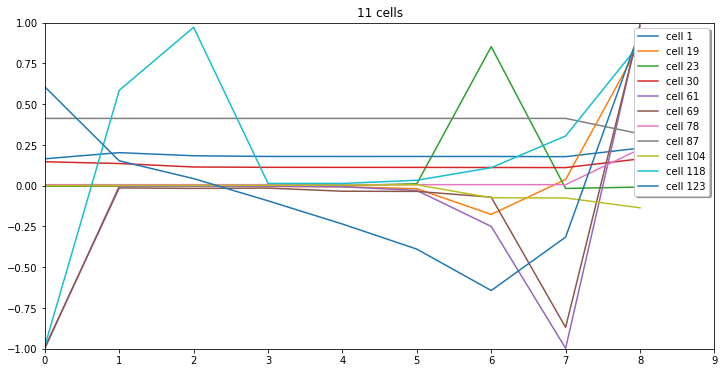

-----------------------------
group 12: [-0.9960492   0.98268694  0.98818207  0.9929122   0.99509805  0.9769747
  0.75904644  0.5121551   0.24853282]
cells: [21, 40, 42, 124]


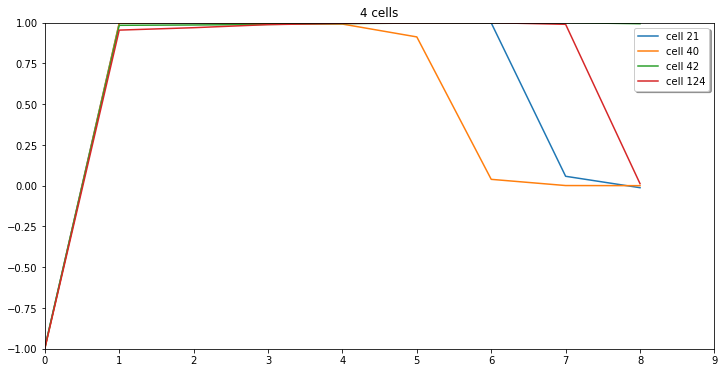

-----------------------------
group 13: [-0.8537352  -0.9289573  -0.74268806 -0.03061043  0.5489267   0.89511967
  0.93801886  0.8722884   0.30323714]
cells: [6, 12, 33, 38, 39, 46, 53, 59]


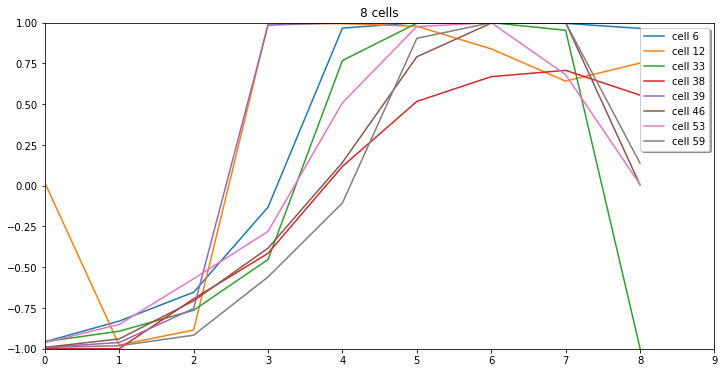

-----------------------------
group 14: [ 0.92026436  0.7780096   0.6362196   0.4998029   0.08270653 -0.41507187
 -0.70106566 -0.7439666  -0.5570655 ]
cells: [3, 66, 74, 83, 116, 117]


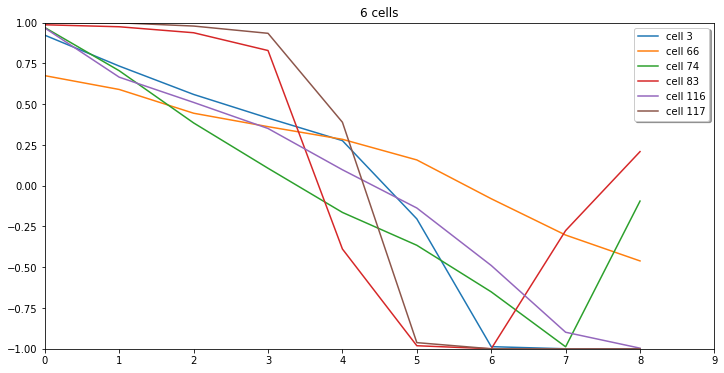

In [43]:
analyze_cells(gates_avg['hidden'], 15, ylim=(-1,1))